# Troubleshooting getCl integration

In [56]:
import crosspower as cp
import FisherCl as fcl # branch quickCl
#import camb

# set plotting to be in the notebook instead of its own qt window
%matplotlib inline

In [57]:
# Create a Fisher Matrix object
import time
reload(fcl.cp)
reload(fcl)
z0 = 0.3
zmax = 4
nBins = 4
lmax = 1000
AccuracyBoost = 3
doNorm = True #False
nz = 100000

starttime = time.time()
Fobj = fcl.FisherMatrix(lmax=lmax,z0=z0,zmax=zmax,nBins=nBins,AccuracyBoost=AccuracyBoost,doNorm=doNorm,nz=nz)
endtime = time.time()

print 'time elapsed: ', endtime-starttime, ' seconds'
print 'time elapsed: ', (endtime-starttime)/60., ' minutes'
print 'time elapsed: ', (endtime-starttime)/3600., ' hours'

print 'binAs: ',Fobj.binAs
print 'binBs: ',Fobj.binBs

creating MatterPower object...
zs.size:  99998
creating Window object...
calculating window  0 ... 


KeyboardInterrupt: 

In [ ]:
# save it
"""
import pickle

#filehandler = open('Fisher_4_4E.obj','w') # lmax=1000, nonlinear=True, ABoost=3, doNorm=True, nz=1e5, branch quickCl
#filehandler = open('Fisher_4_4B.obj','w') # lmax=1000, nonlinear=True, ABoost=3, doNorm=True, branch quickCl
#filehandler = open('Fisher_4_4C.obj','w') # lmax=1000, nonlinear=True, ABoost=3, doNorm=True, branch quickCl
#filehandler = open('Fisher_4_4A.obj','w') # lmax=1000, nonlinear=True, ABoost=3, doNorm=True, branch master

# ditch the myPk and myWin parts since pickle can't handle classes within a class
myPkTemp = Fobj.myPk
myWinTemp = Fobj.myWin
Fobj.myPk = 0
Fobj.myWin = 0
pickle.dump(Fobj,filehandler)
filehandler.close()

# put them back
Fobj.myPk = myPkTemp
Fobj.myWin = myWinTemp
print 'done'
"""

In [123]:
# load saved Fobj
# get lensing and galaxy Fisher matrix to add

import FisherCl as fcl
import crosspower as cp
import pickle
#filehandler = open('Fisher_4_4E.obj','r') # lmax=1000, nonlinear=True, ABoost=3, doNorm=True, nz=1e5, branch quickCl
filehandler = open('Fisher_4_4D.obj','r') # accuracyBoost=3,doNorm=True,lmax=1000; from FisherCl branch master
#filehandler = open('Fisher_4_4C.obj','r') # accuracyBoost=3,doNorm=False,lmax=1000; from FisherCl branch quickCl
#filehandler = open('Fisher_4_4B.obj','r') # accuracyBoost=3,doNorm=True,lmax=1000; from FisherCl branch quickCl
#filehandler = open('Fisher_4_4A.obj','r') # lmax=1000, nonlinear=True, ABoost=3, doNorm=True, branch master

Fobj = pickle.load(filehandler) 
lmax = 1000

print Fobj.obsList
print Fobj.paramList


[  0.   1.   2.   3.   4.   6.   7.   8.   9.  12.  13.  14.  18.  19.  24.]
['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'w', 'bin1', 'bin2', 'bin3', 'bin4']


In [124]:
# display the sigmas
# this does not take lmin= 50 into account.
paramList = Fobj.paramList
sigmas = Fobj.getSigmas()
for i, param in enumerate(paramList):
    print param, ': ',sigmas[i]

ombh2 :  0.000248015669489
omch2 :  0.000788003996266
cosmomc_theta :  1.78937887867e-05
As :  1.49529669476e-11
ns :  0.00308358316126
tau :  2.91377124118
mnu :  0.0133178089888
w :  0.017098074712
bin1 :  0.00373669607237
bin2 :  0.00397730986367
bin3 :  0.00632521390216
bin4 :  0.00818064489161


In [125]:
# remake with higher lmin for comparisons
lmin=50
#Fij2 = makeFisher(Fobj,lmin,lmax)
Fij2 = Fobj.makeFisher(lmin,lmax)
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))

building Fisher matrix from components...
invCov.shape:  (15, 15, 999) , dClVecs.shape:  (15, 12, 999)
starting bin set  1  of  12
starting bin set  2  of  12
starting bin set  3  of  12
starting bin set  4  of  12
starting bin set  5  of  12
starting bin set  6  of  12
starting bin set  7  of  12
starting bin set  8  of  12
starting bin set  9  of  12
starting bin set  10  of  12
starting bin set  11  of  12
starting bin set  12  of  12


In [126]:
# multiply fsky factor
fsky = 0.5
print 'fsky =',fsky
print 'fsky^(-1/2) =',1/np.sqrt(fsky)
Fij2 *= fsky
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))

fsky = 1
fsky^(-1/2) = 1.0


In [127]:
# add prior on Tau
"""
tauNum = 5
priorTauSigma = 0.02
tauPrior = 1/priorTauSigma**2
print Fij2[tauNum,tauNum]
Fij2[tauNum,tauNum] = Fij2[tauNum,tauNum] + tauPrior 
print Fij2[tauNum,tauNum]

# remake sigmas2 with this
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))
"""

'\ntauNum = 5\npriorTauSigma = 0.02\ntauPrior = 1/priorTauSigma**2\nprint Fij2[tauNum,tauNum]\nFij2[tauNum,tauNum] = Fij2[tauNum,tauNum] + tauPrior \nprint Fij2[tauNum,tauNum]\n\n# remake sigmas2 with this\nsigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))\n'

In [128]:
for i,p in enumerate(paramList):
    print p, sigmas2[i]

ombh2 0.000248015669489
omch2 0.000788003996266
cosmomc_theta 1.78937887867e-05
As 1.49529669476e-11
ns 0.00308358316126
tau 2.91377124118
mnu 0.0133178089888
w 0.017098074712
bin1 0.00373669607237
bin2 0.00397730986367
bin3 0.00632521390216
bin4 0.00818064489161


In [129]:
# check the power spectra for blips or worse
print 'example: (5,5,999) means 999 symmetric 5x5 matrices, one at each ell'
print Fobj.crossCls.shape
print Fobj.crossClsPlus.shape
print Fobj.crossClsMinus.shape
nMaps = Fobj.nBins+1
ells = Fobj.ells
print 'nMaps =',nMaps
nCosParams = Fobj.nParams - Fobj.nBins
print 'nCosParams =',nCosParams
paramList = Fobj.paramList
print 'paramList =',paramList
obsList = Fobj.obsList
print 'obsList =',obsList
obsNames = Fobj.obsNames
#obsNames = ['k,k', 'k,g1', 'k,g2', 'k,g3', 'k,g4', 'g1,g1', 'g1,g2', 'g1,g3', 'g1,g4', 'g2,g2', 'g2,g3', 'g2,g4', 'g3,g3', 'g3,g4', 'g4,g4']
print 'obsNames =',obsNames


example: (5,5,999) means 999 symmetric 5x5 matrices, one at each ell
(5, 5, 999)
(5, 5, 8, 999)
(5, 5, 8, 999)
nMaps = 5
nCosParams = 8
paramList = ['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu', 'w', 'bin1', 'bin2', 'bin3', 'bin4']
obsList = [  0.   1.   2.   3.   4.   6.   7.   8.   9.  12.  13.  14.  18.  19.  24.]
obsNames = ['k,k', 'k,g1', 'k,g2', 'k,g3', 'k,g4', 'g1,g1', 'g1,g2', 'g1,g3', 'g1,g4', 'g2,g2', 'g2,g3', 'g2,g4', 'g3,g3', 'g3,g4', 'g4,g4']


# Plot the power spectra used to make the discrete derivatives

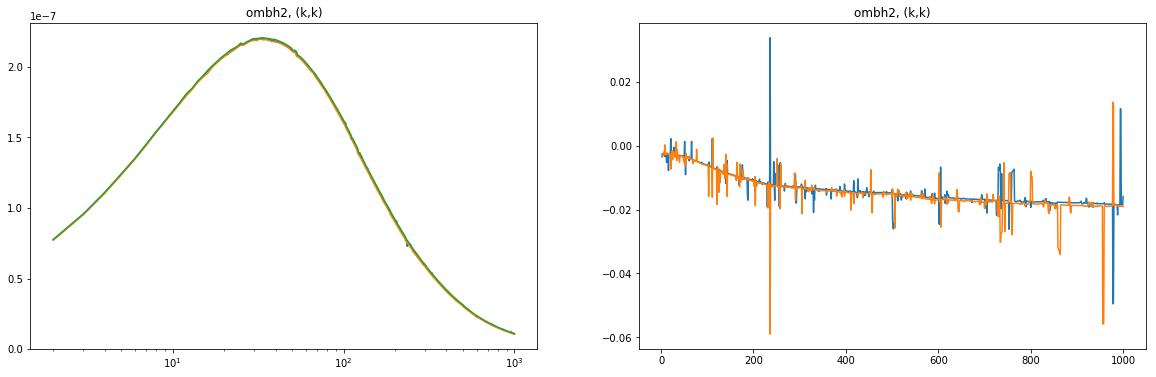

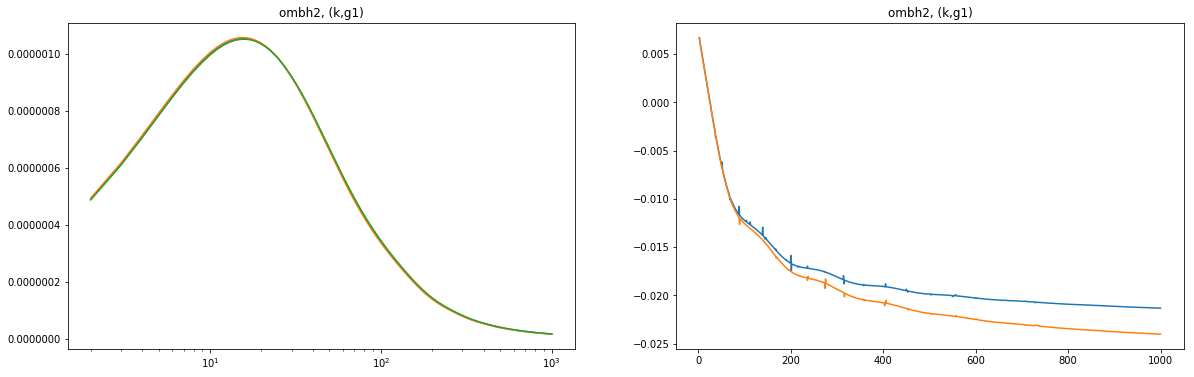

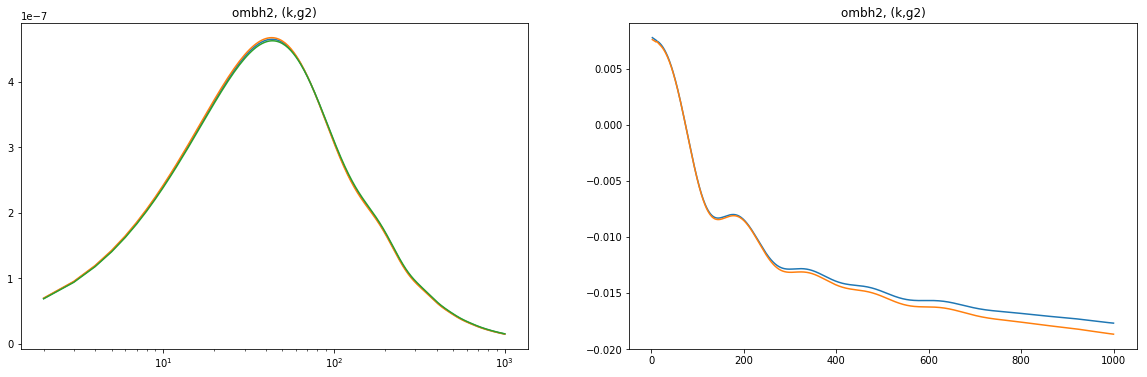

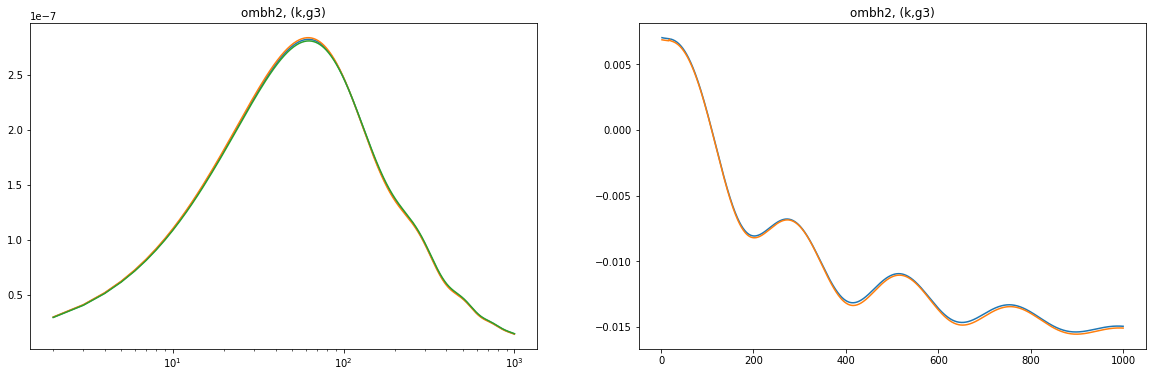

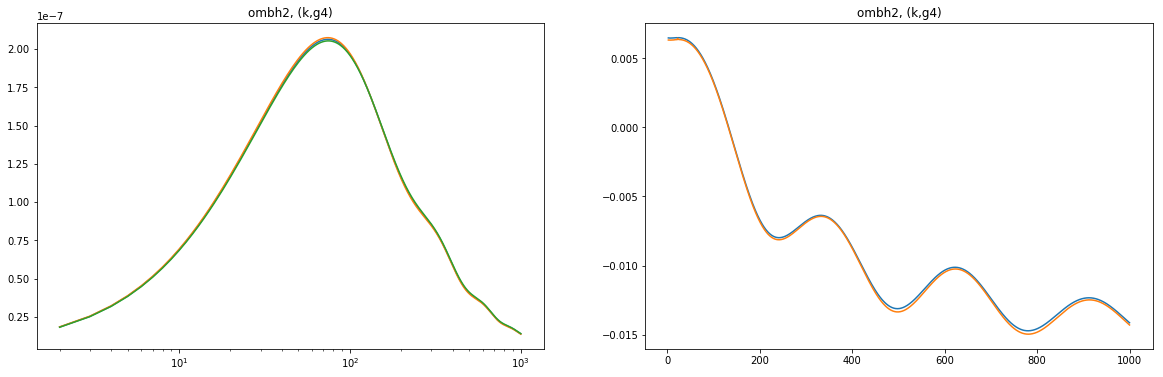

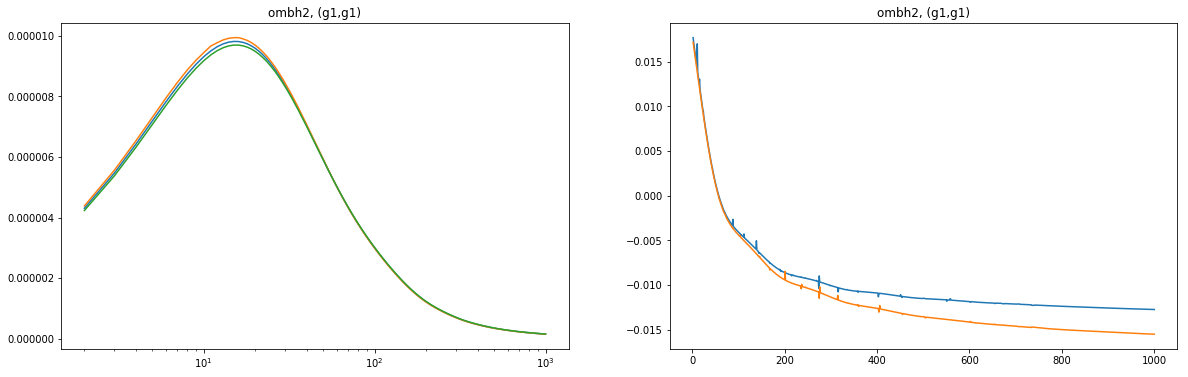

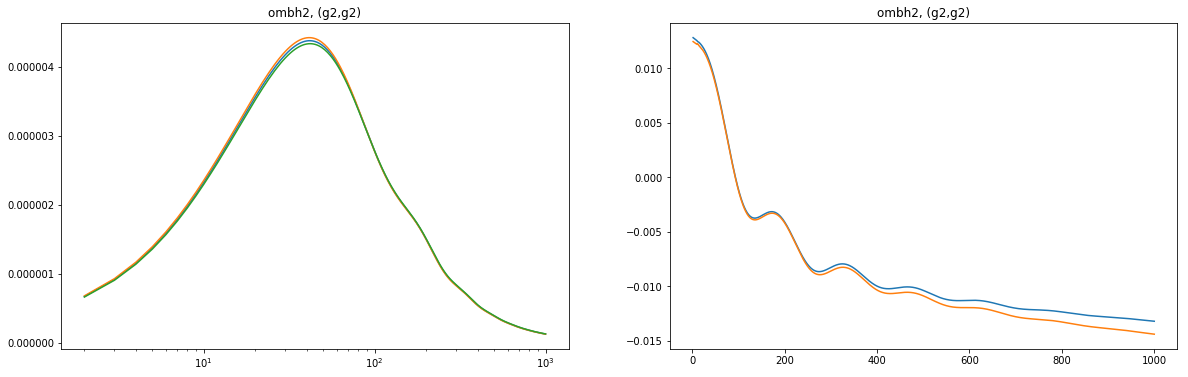

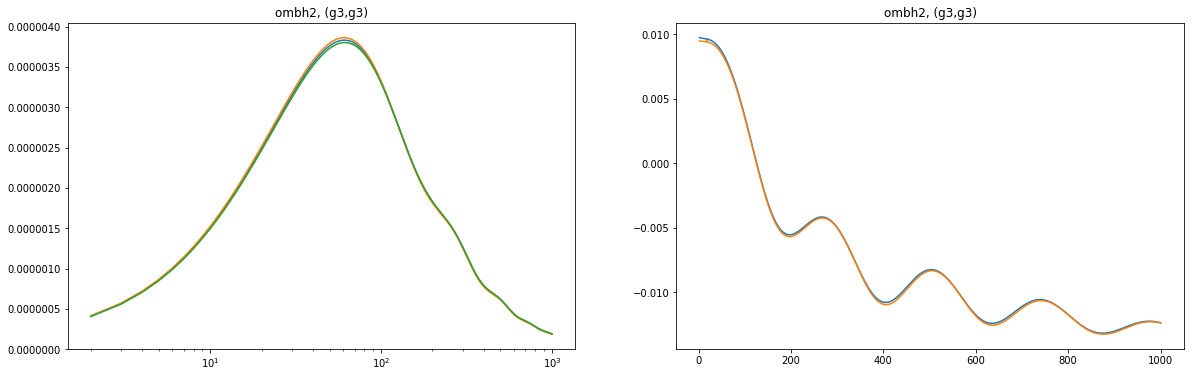

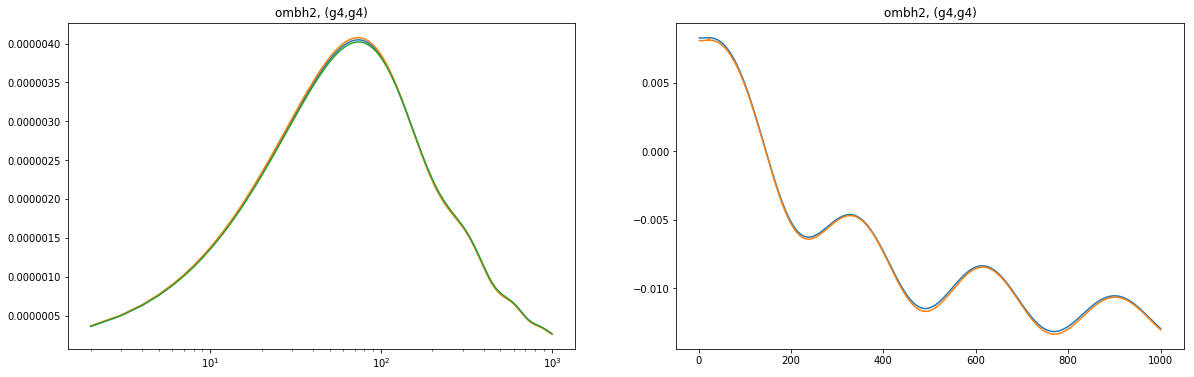

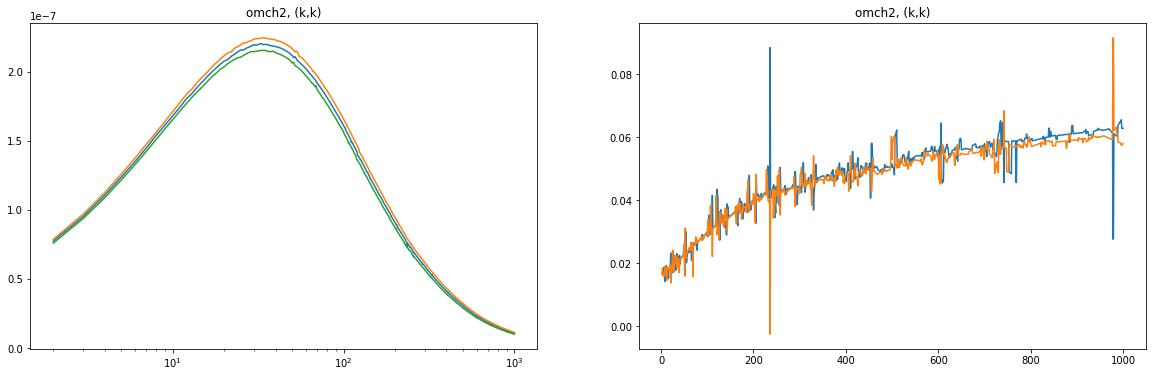

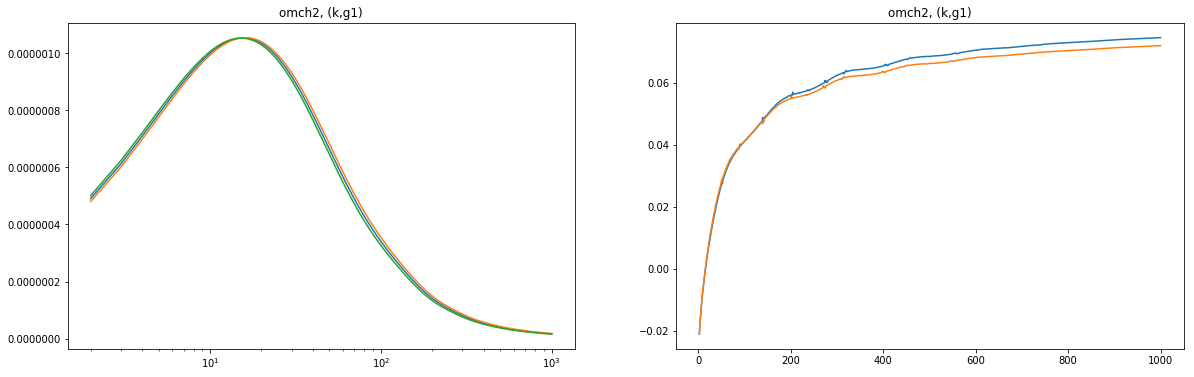

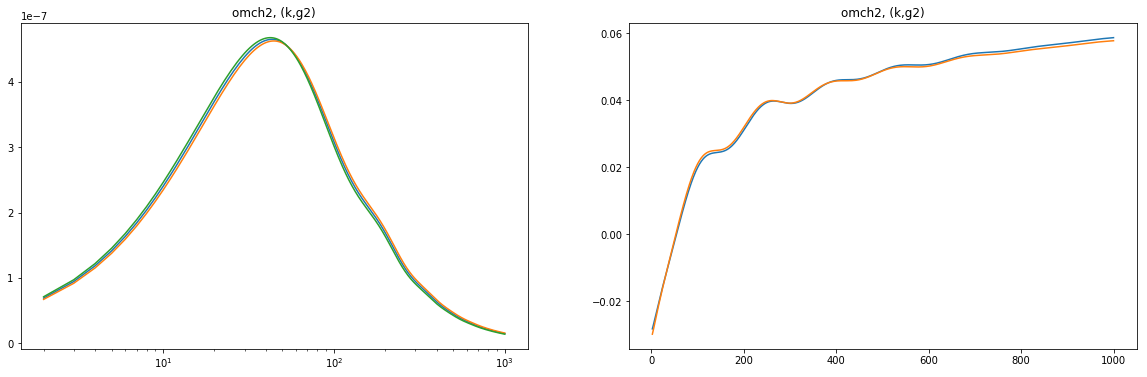

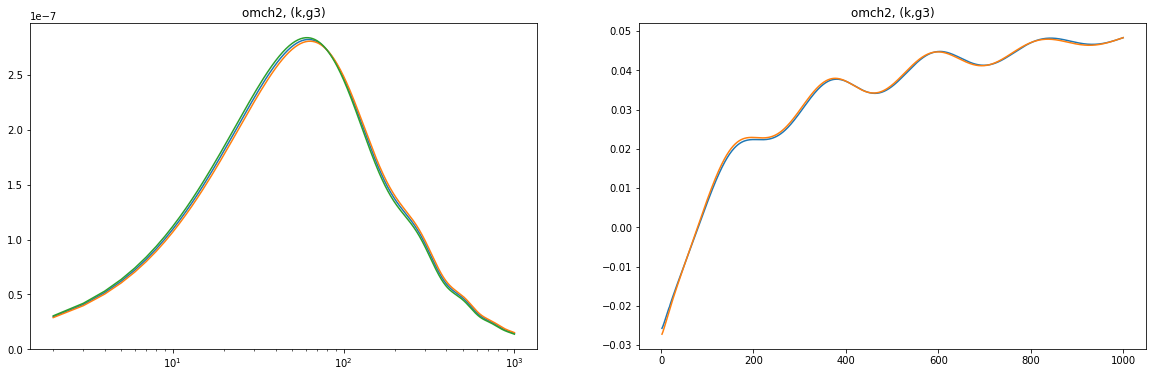

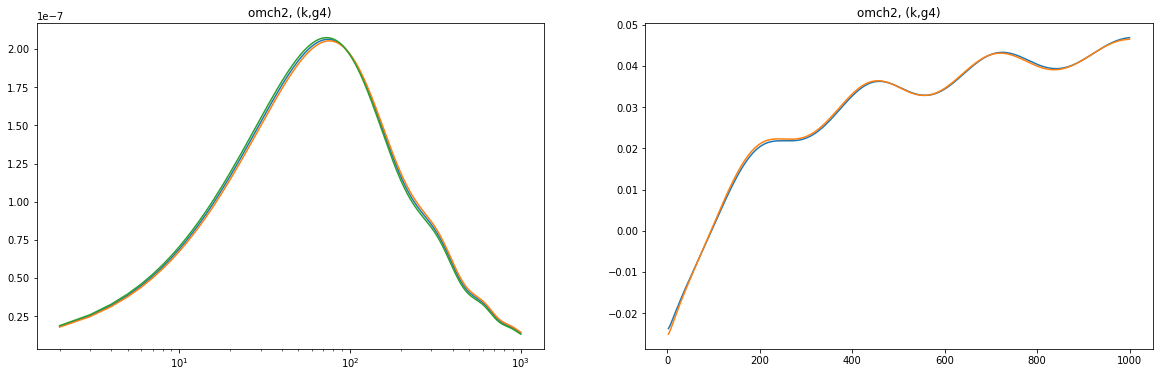

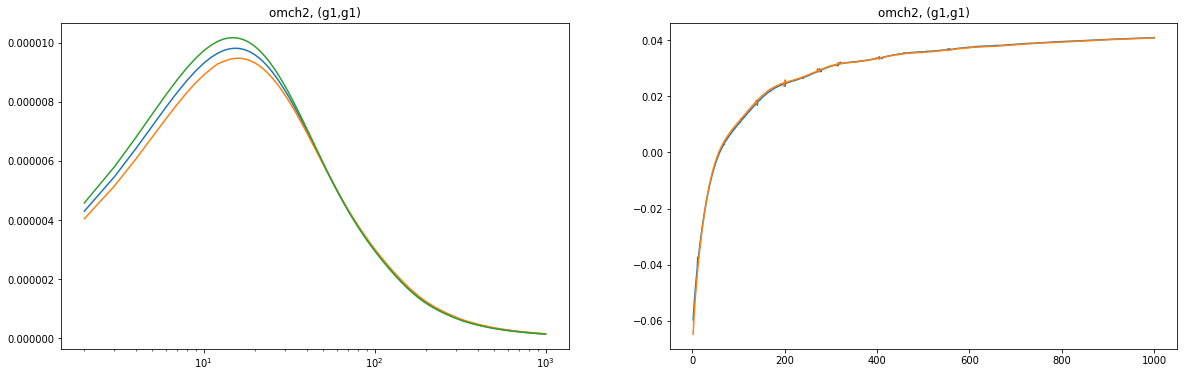

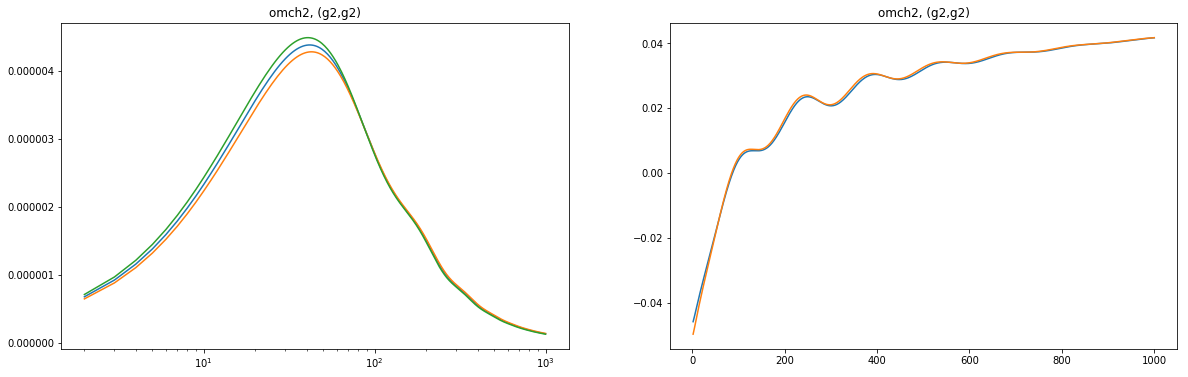

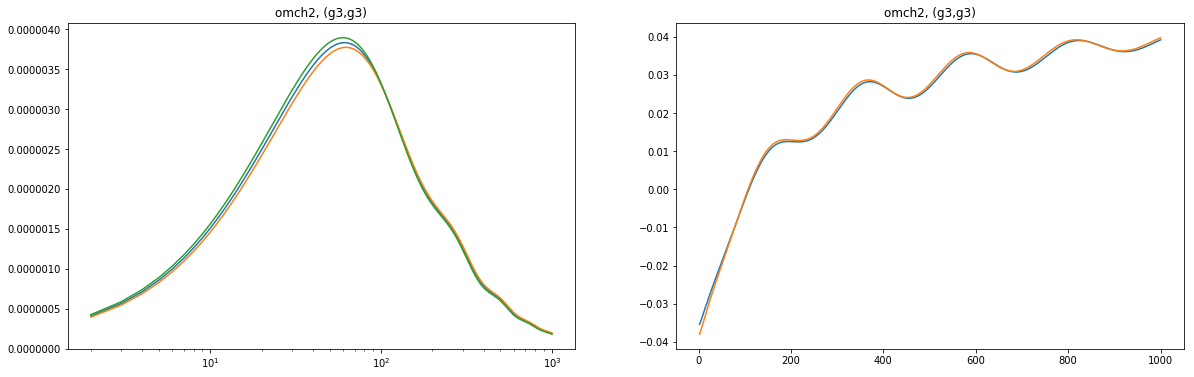

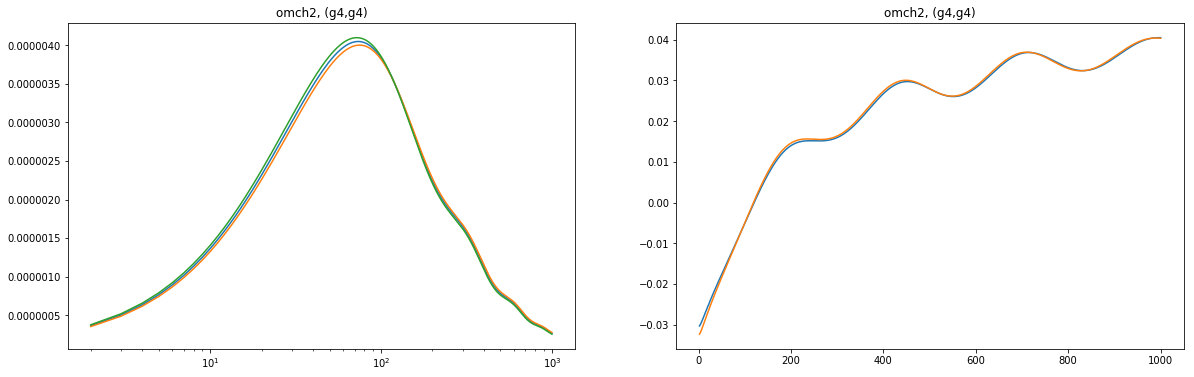

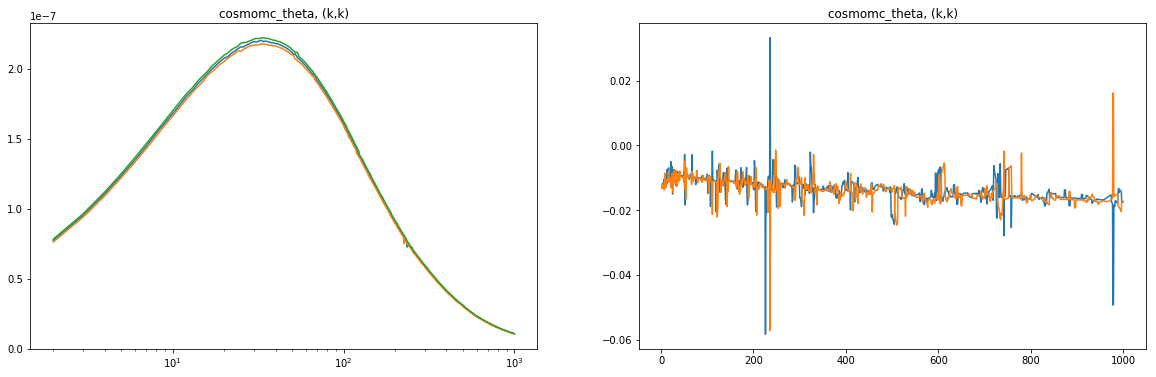

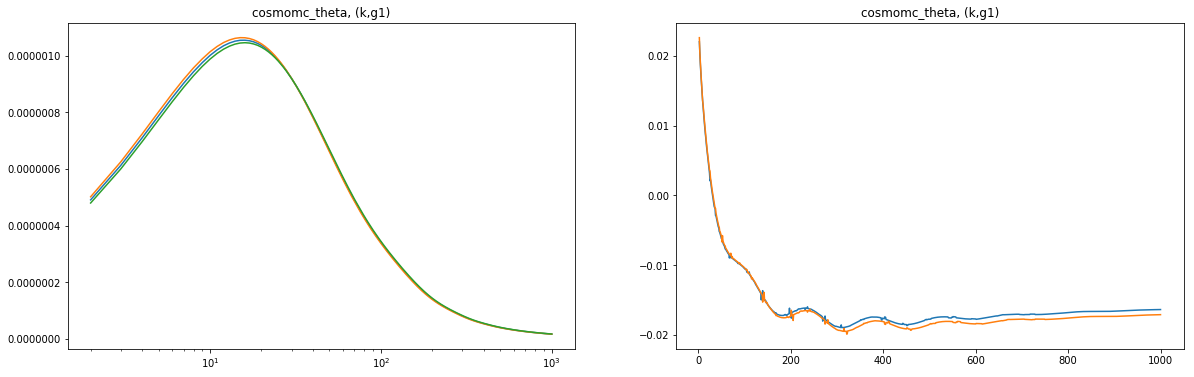

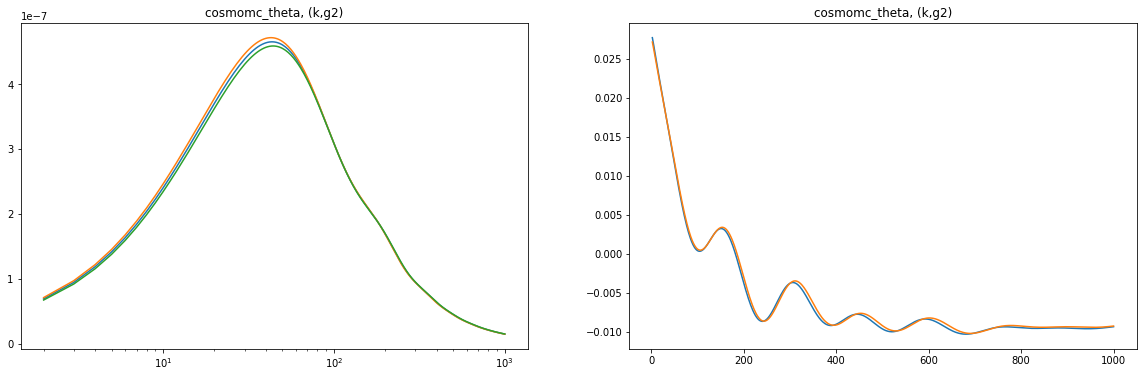

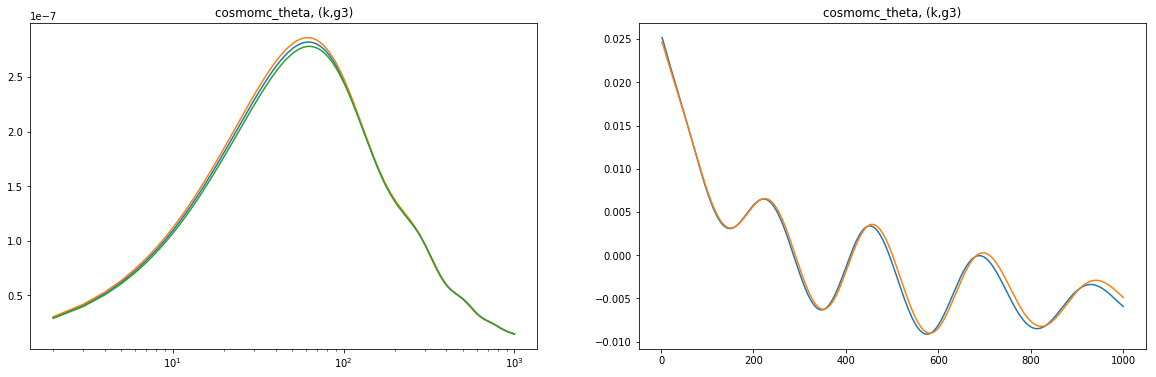

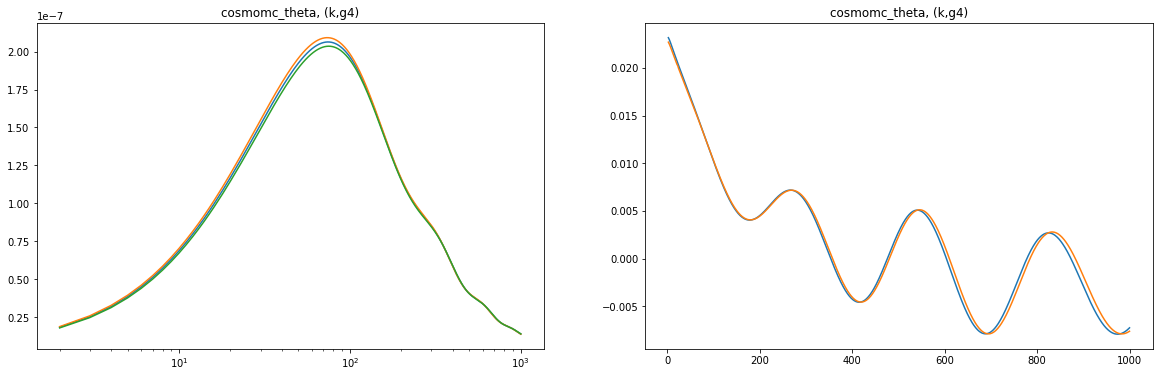

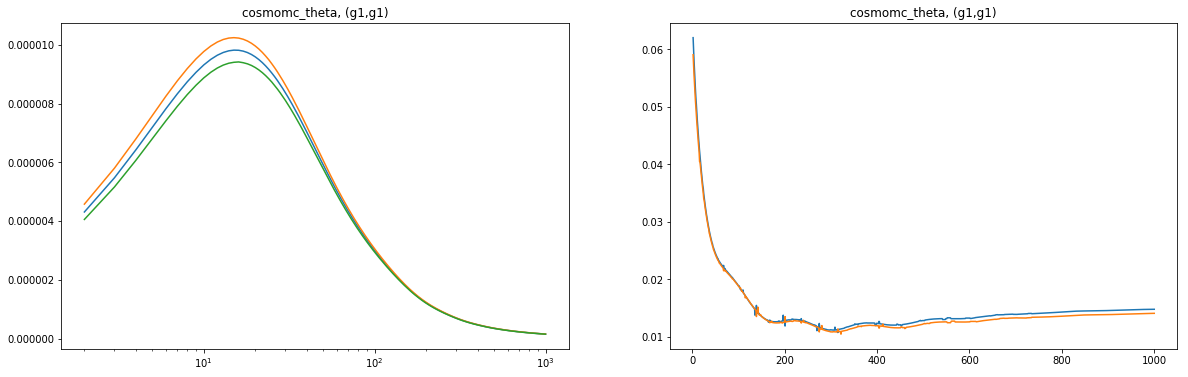

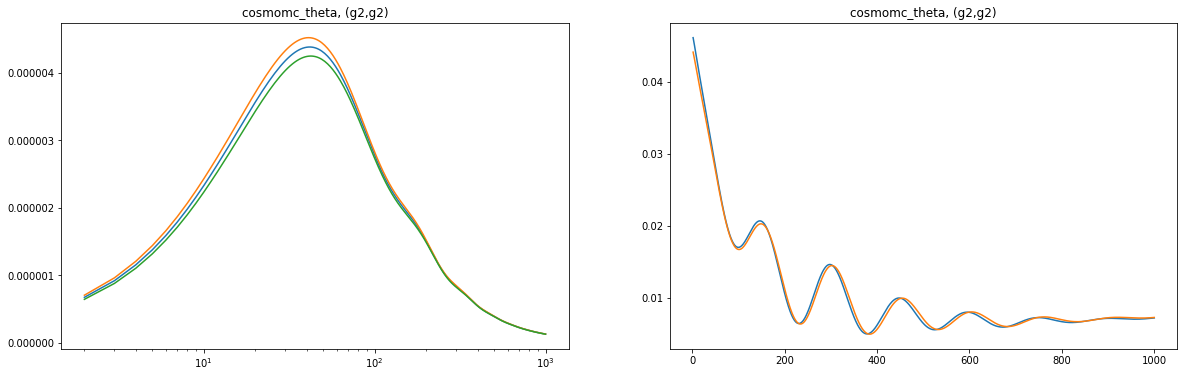

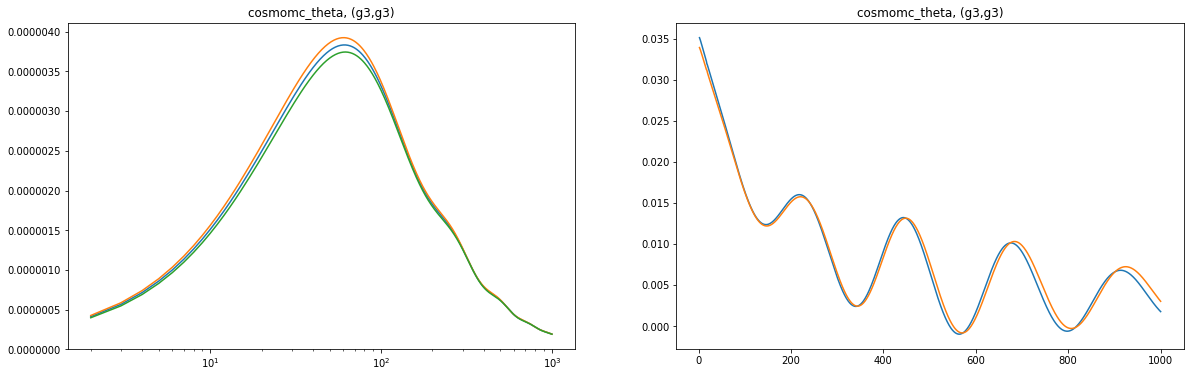

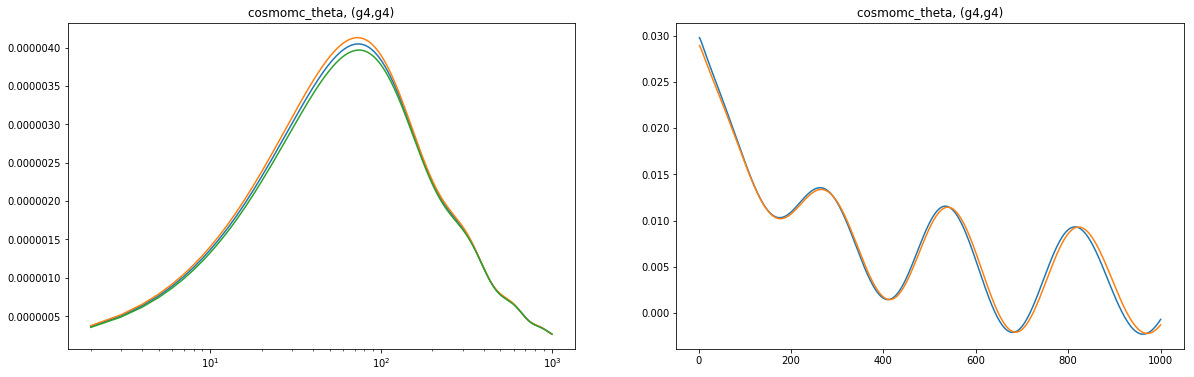

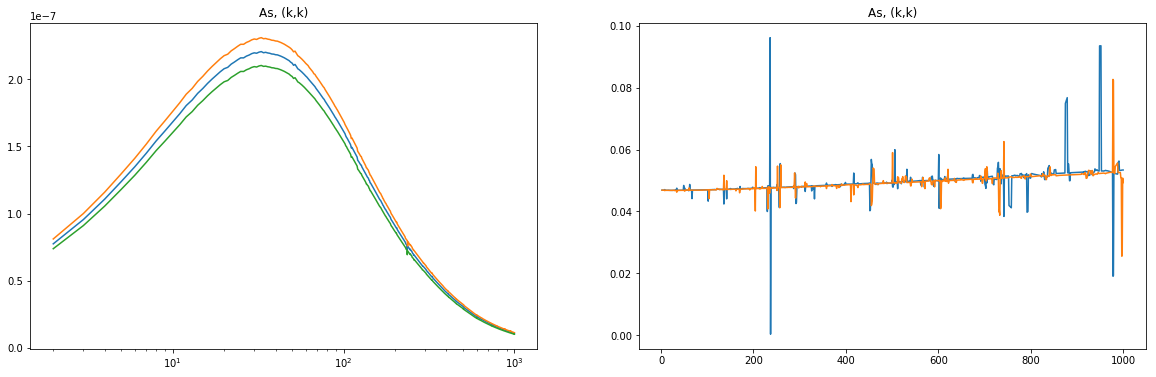

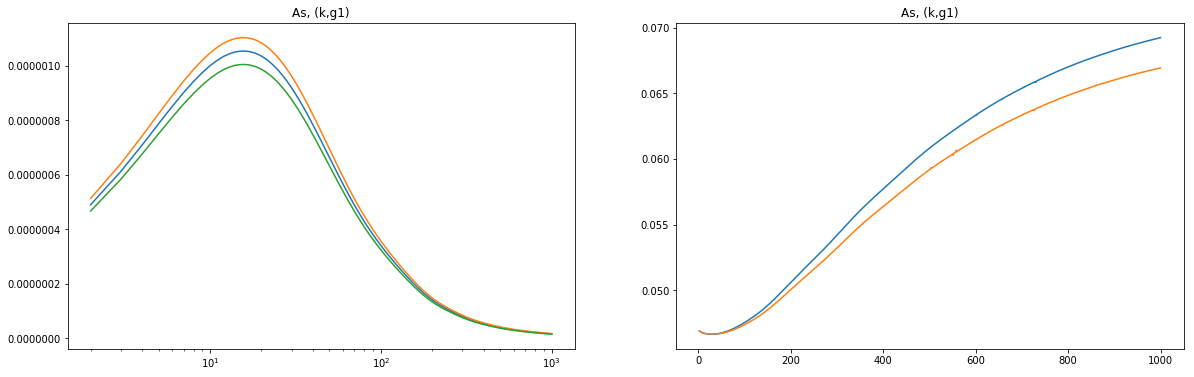

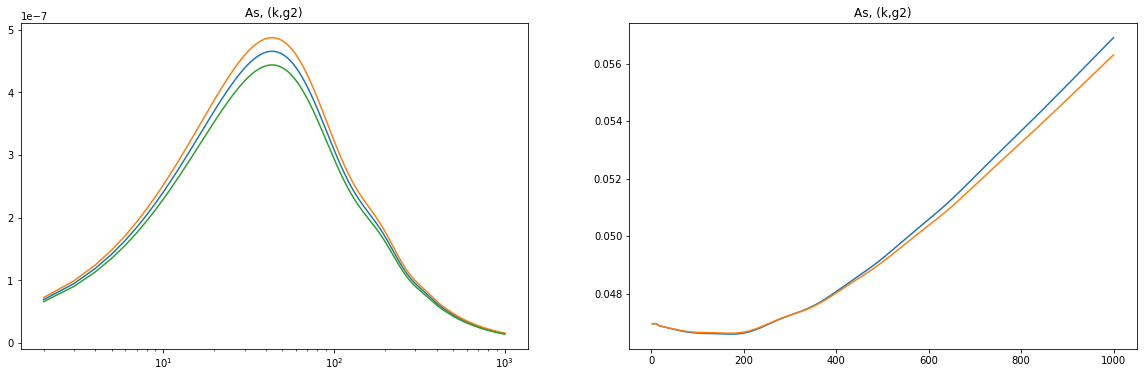

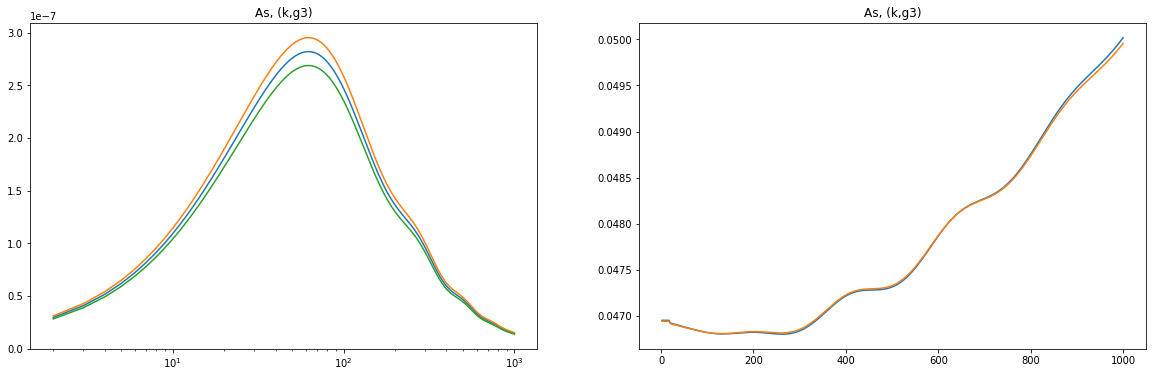

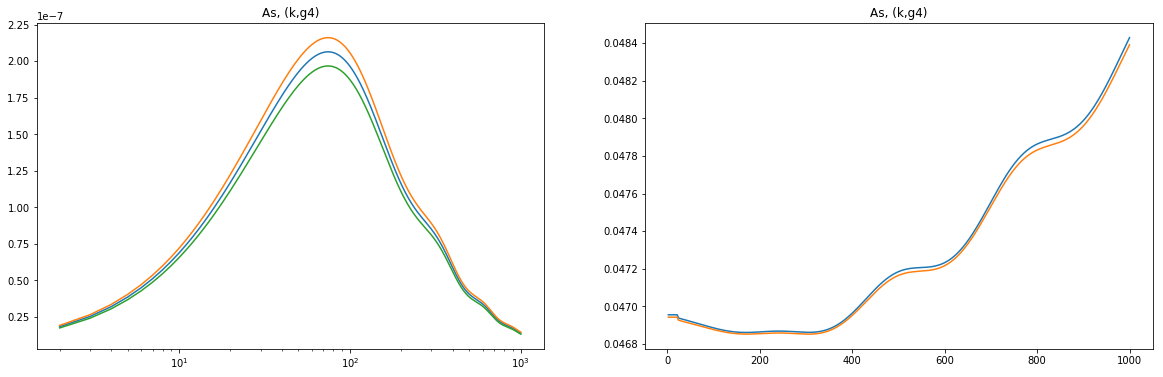

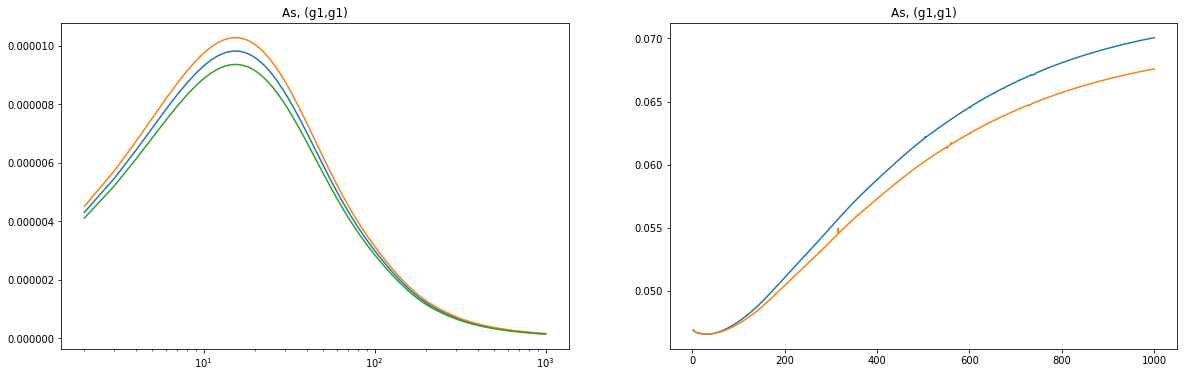

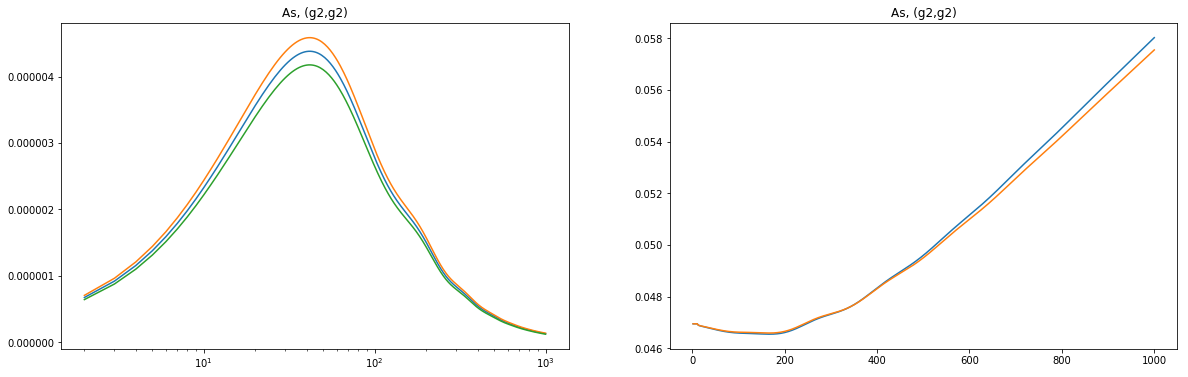

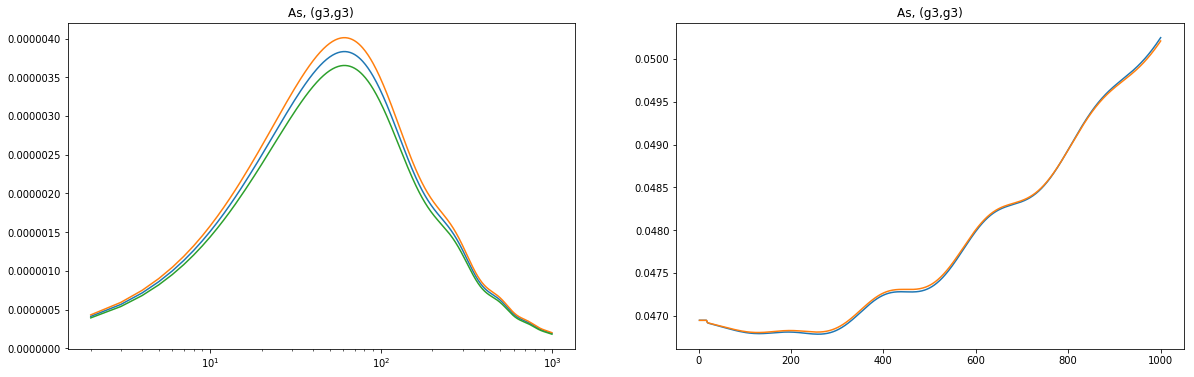

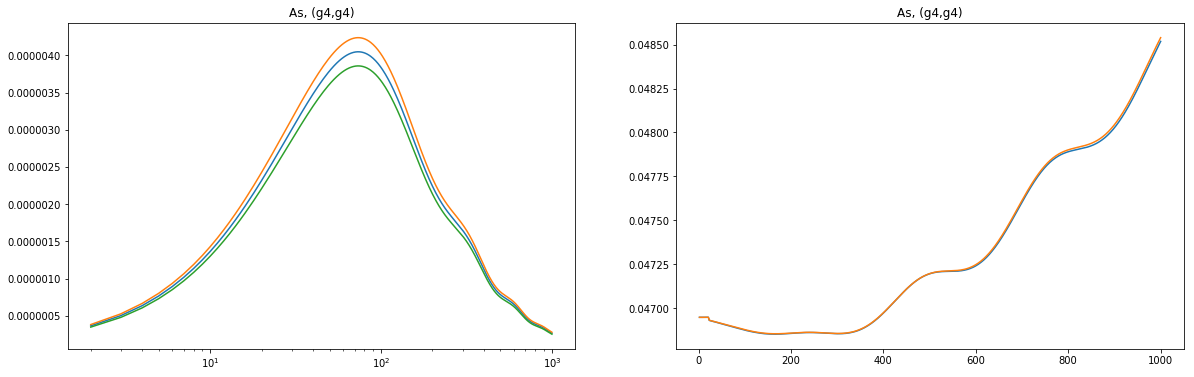

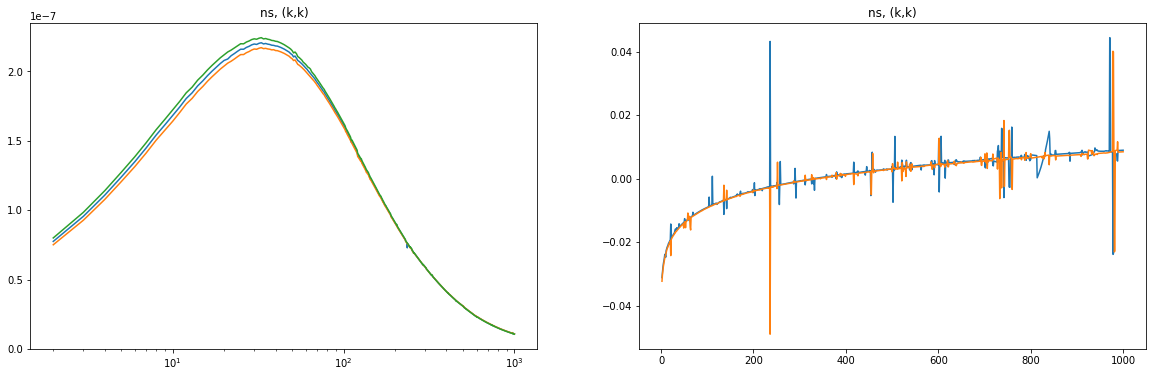

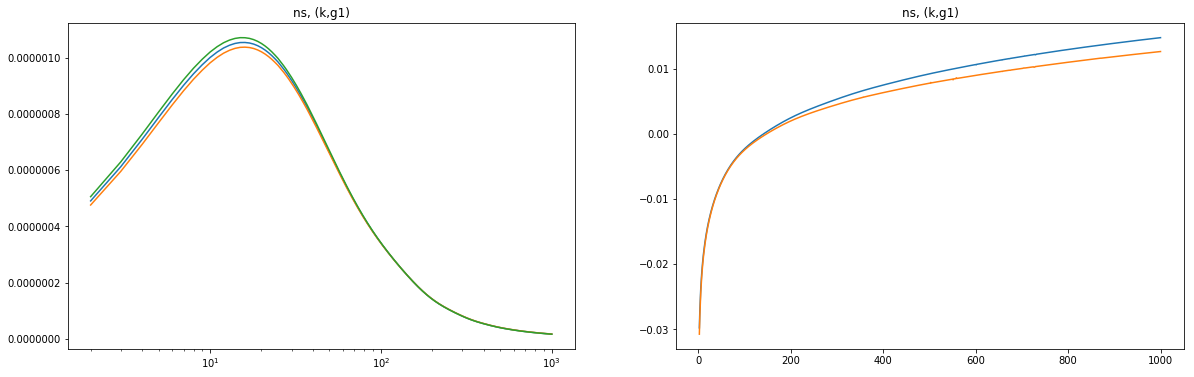

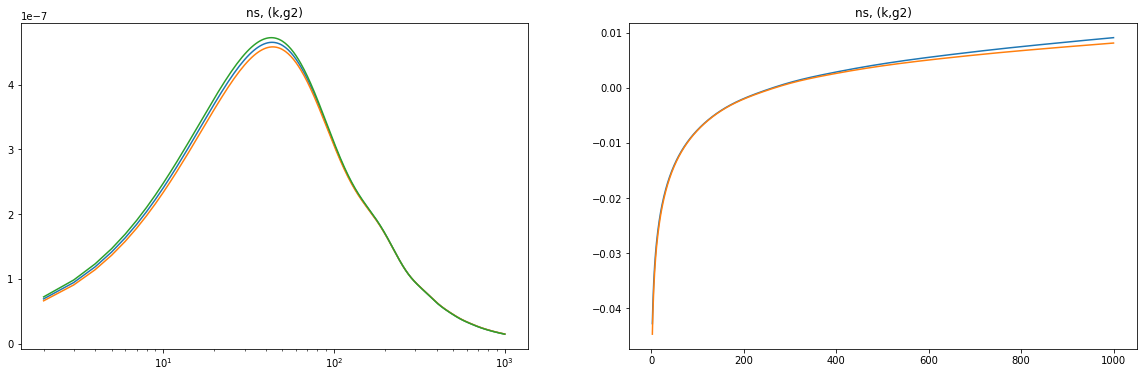

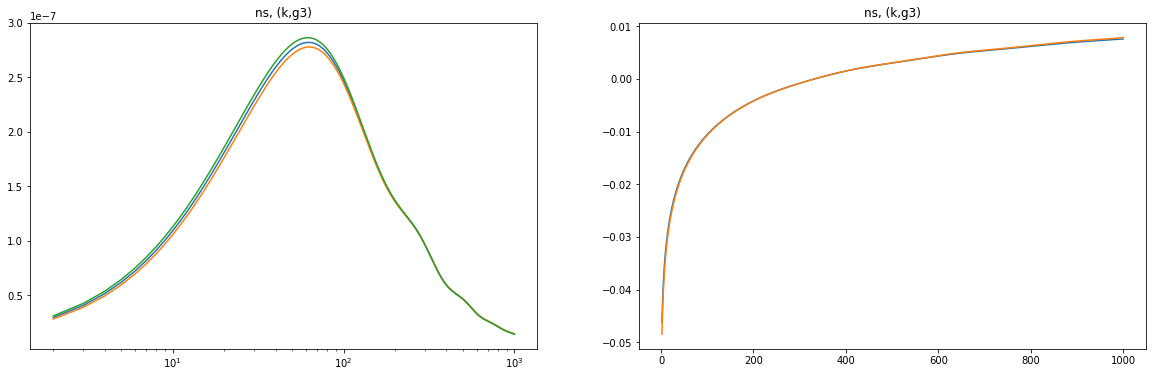

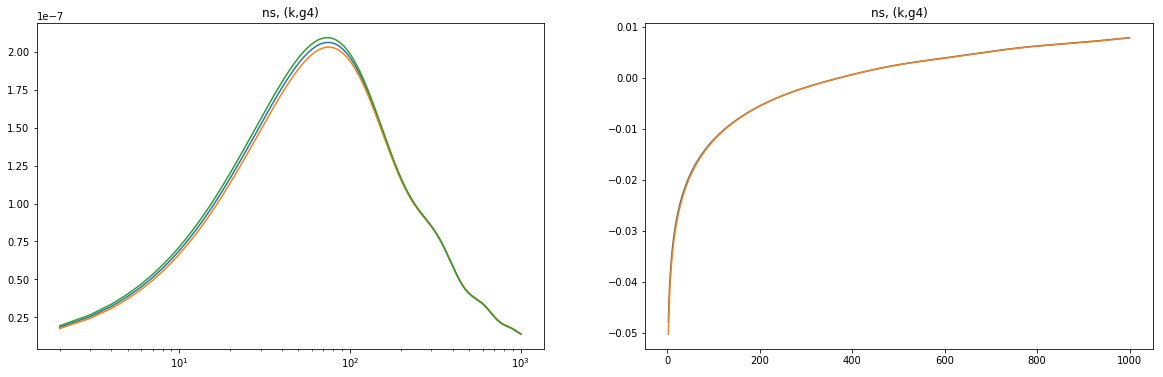

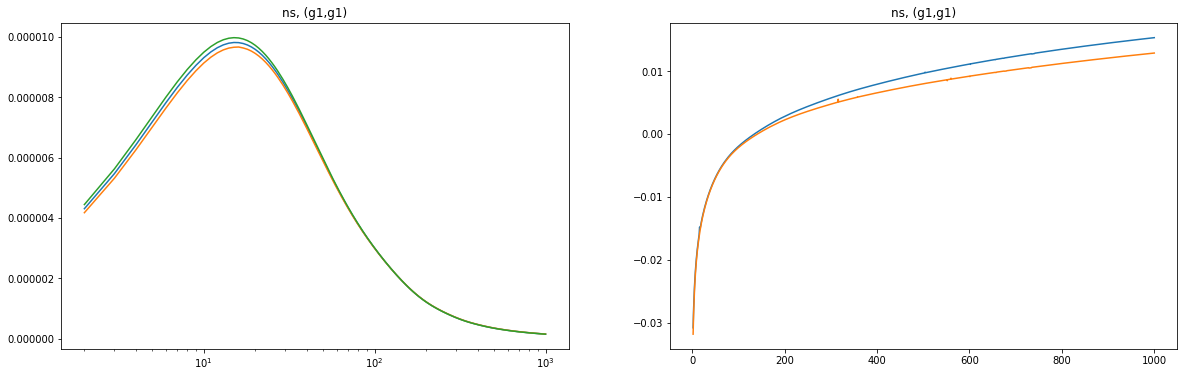

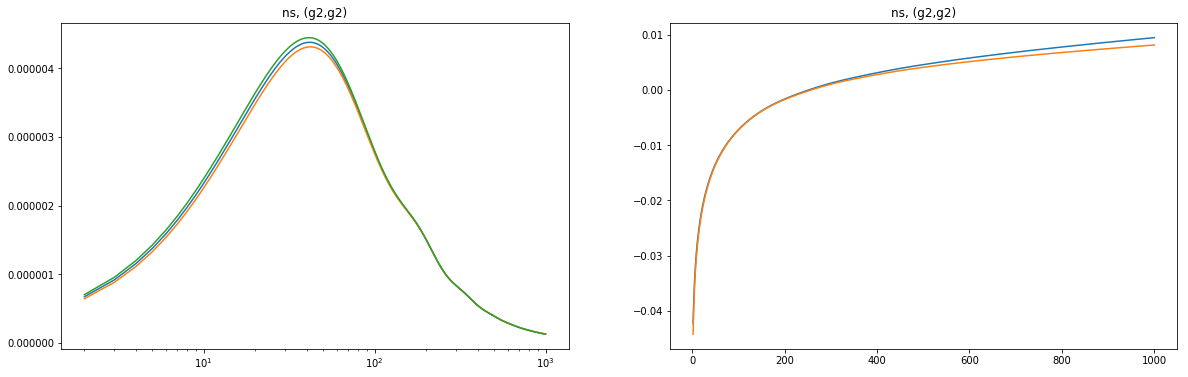

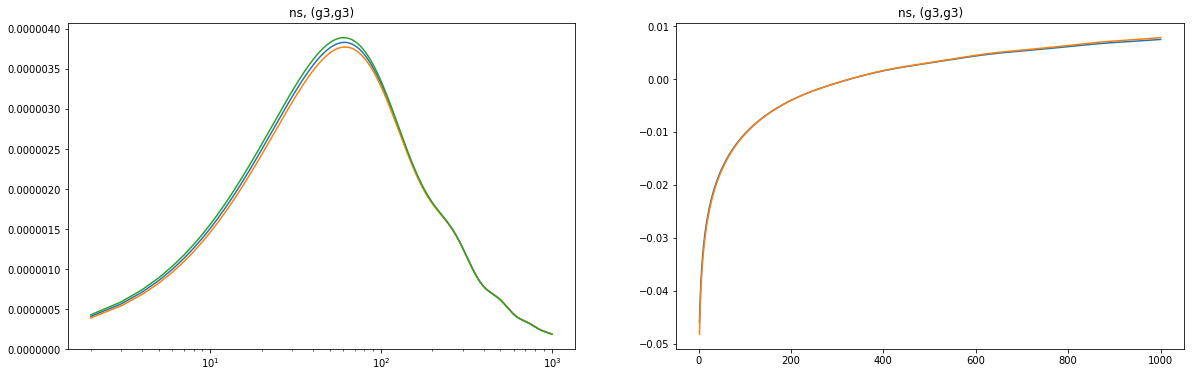

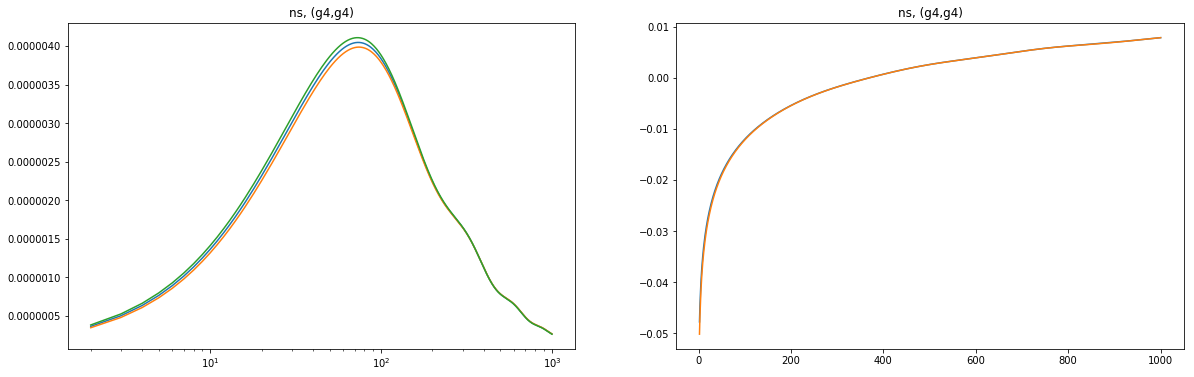

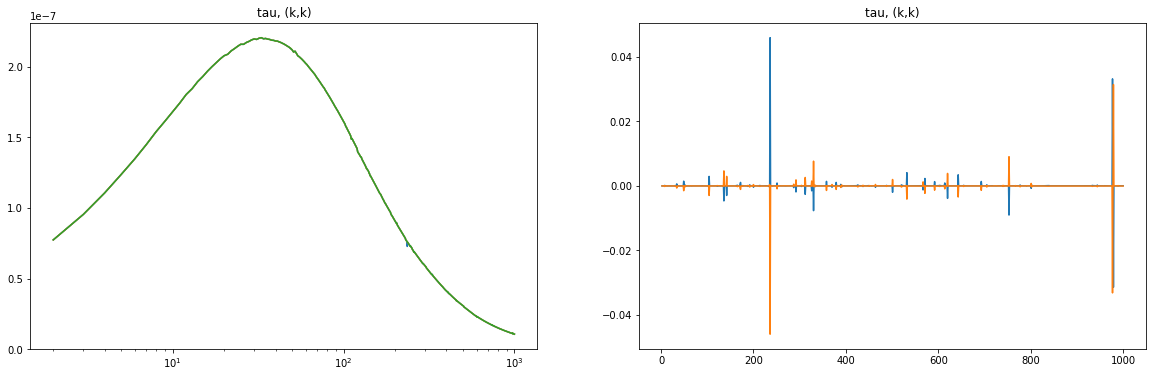

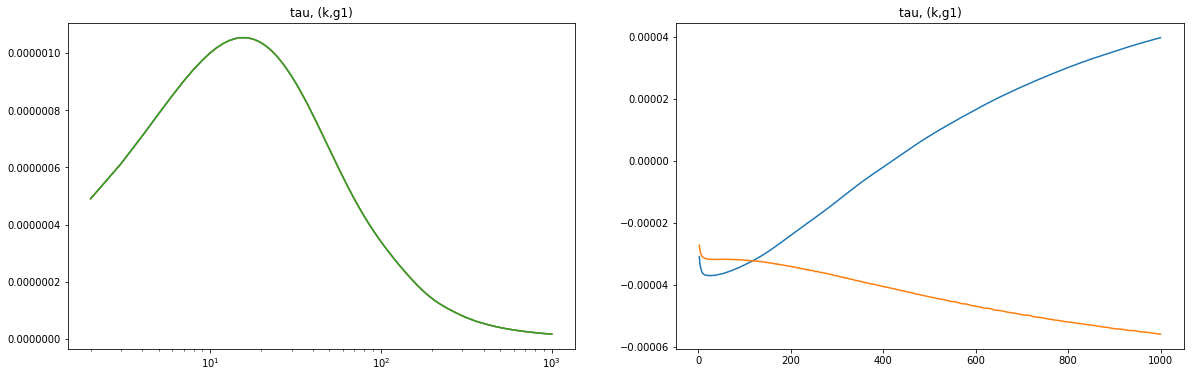

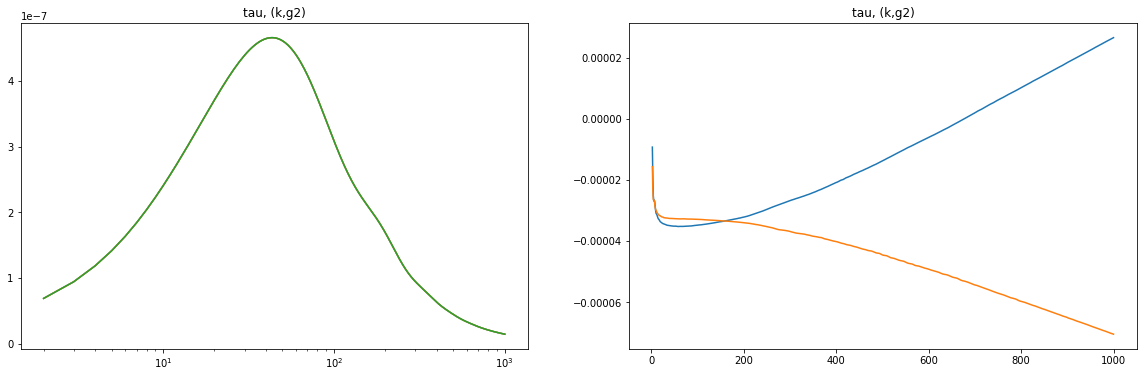

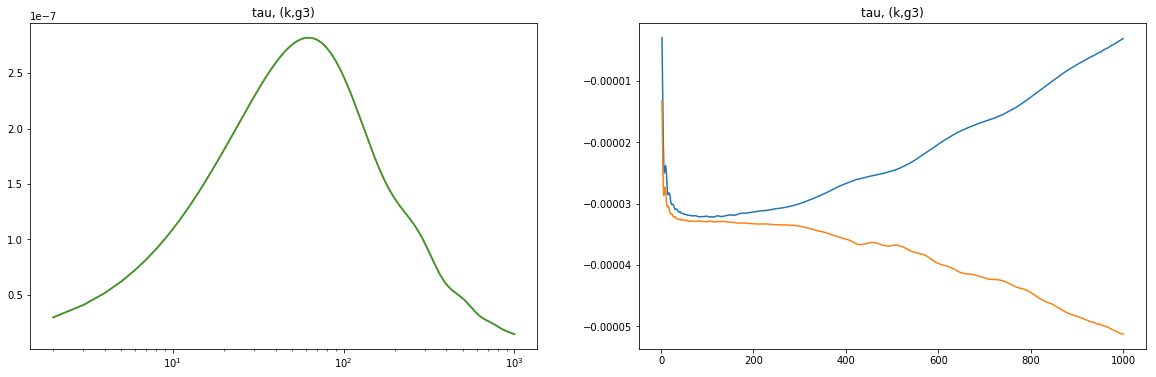

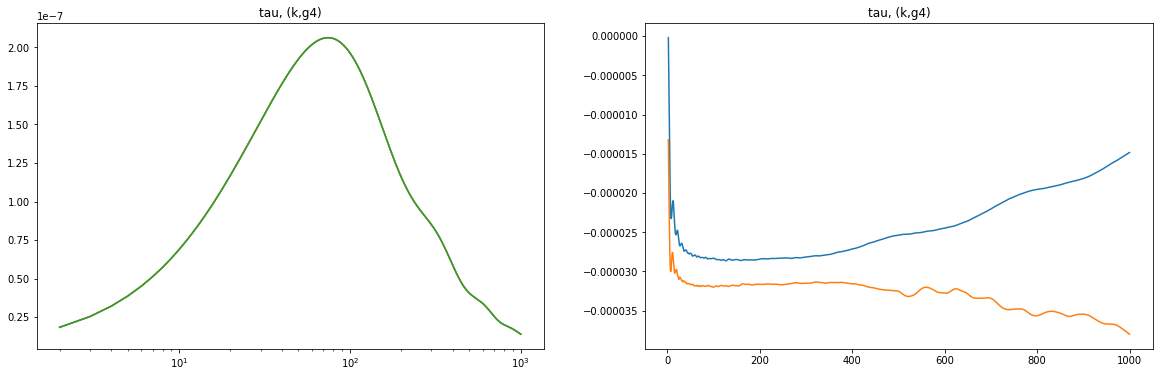

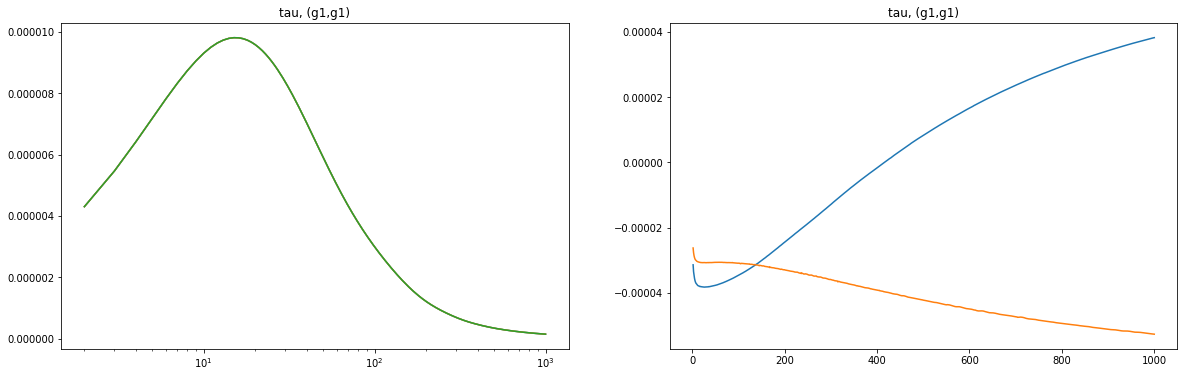

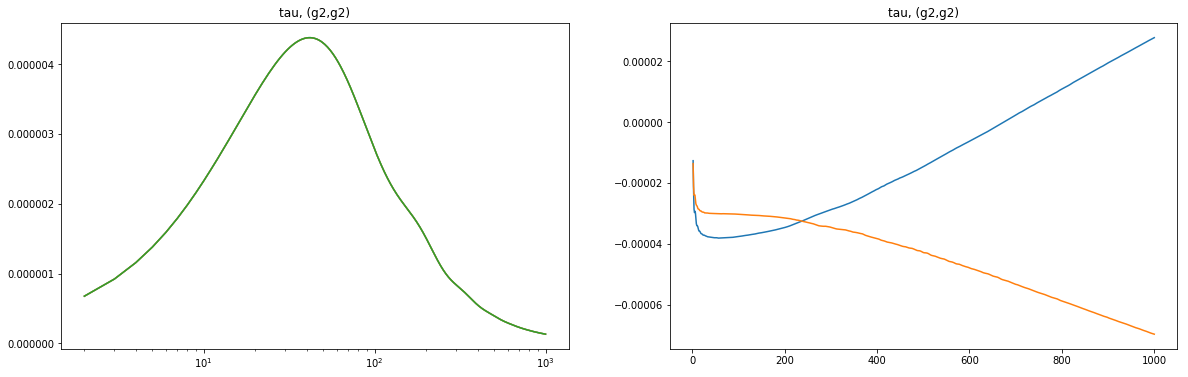

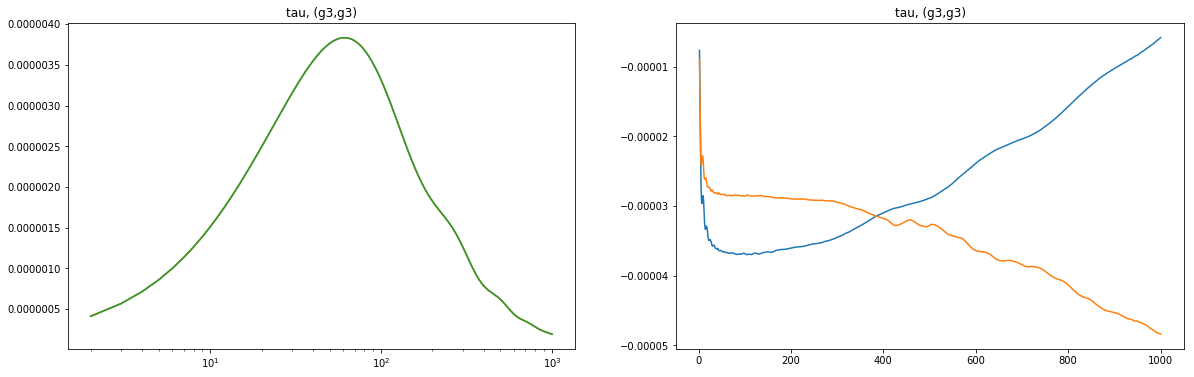

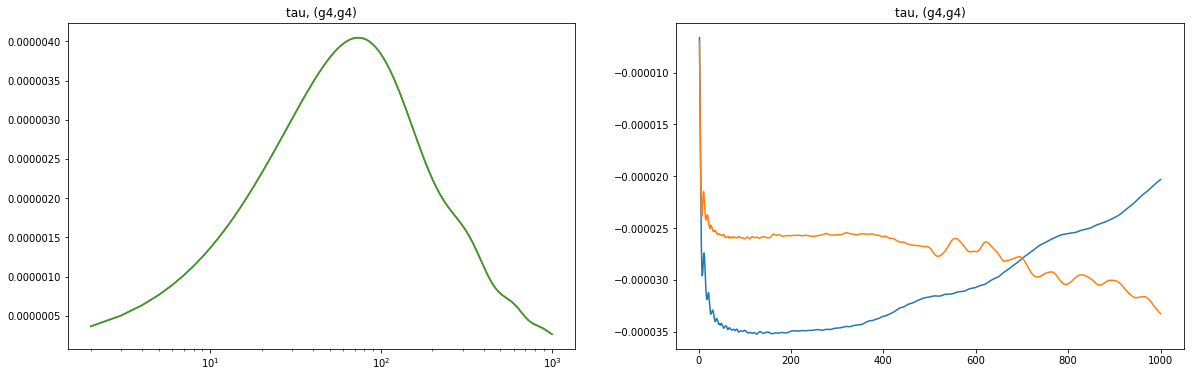

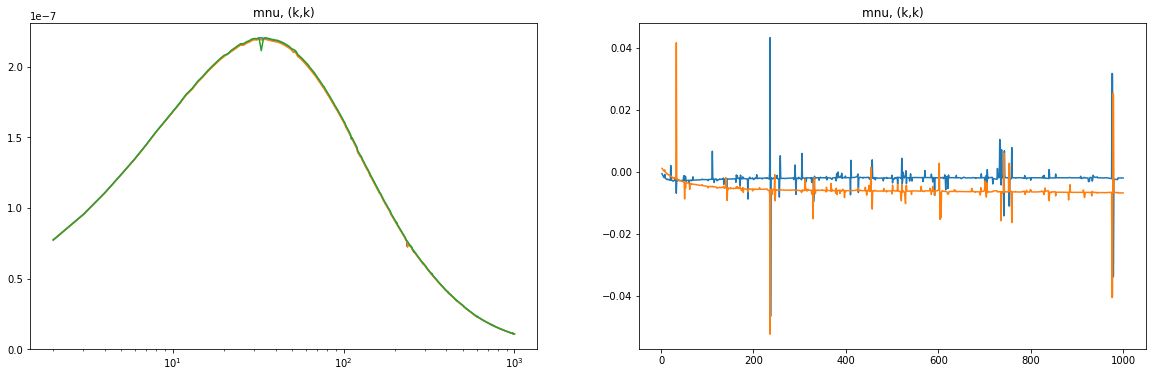

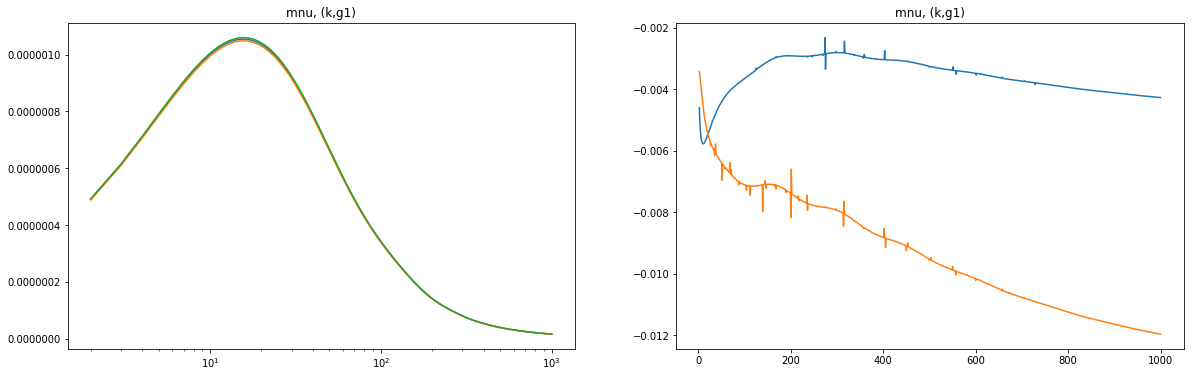

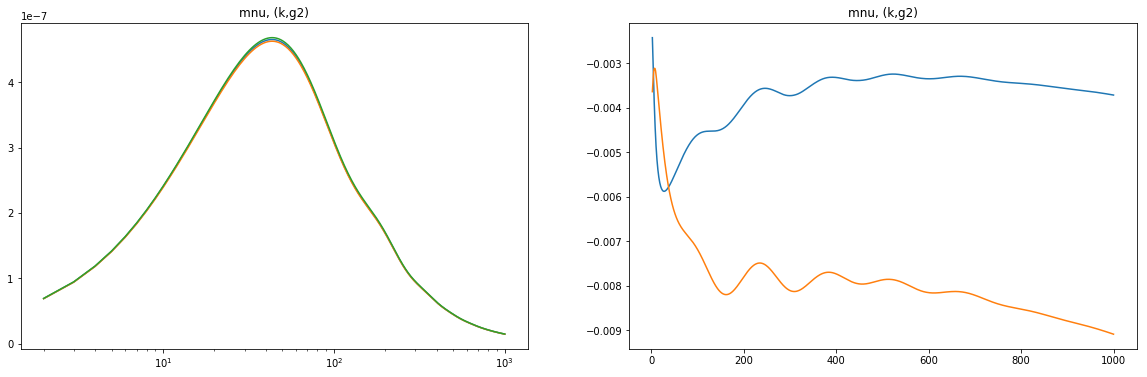

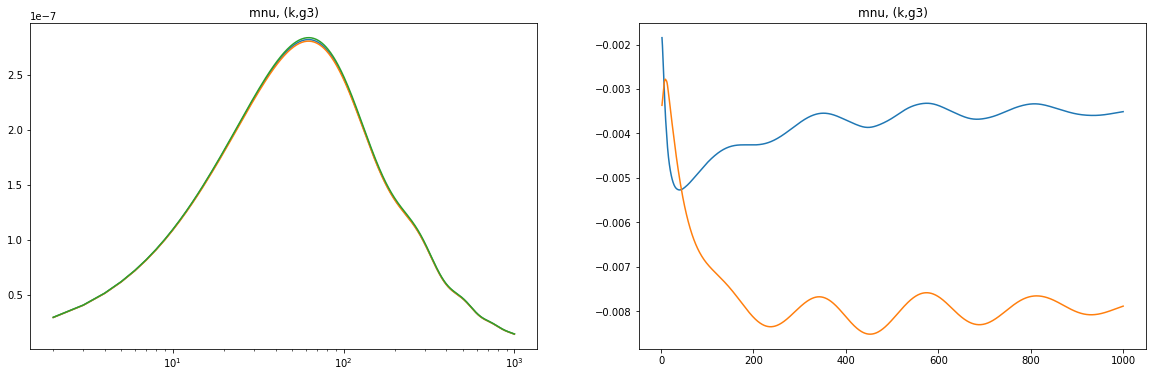

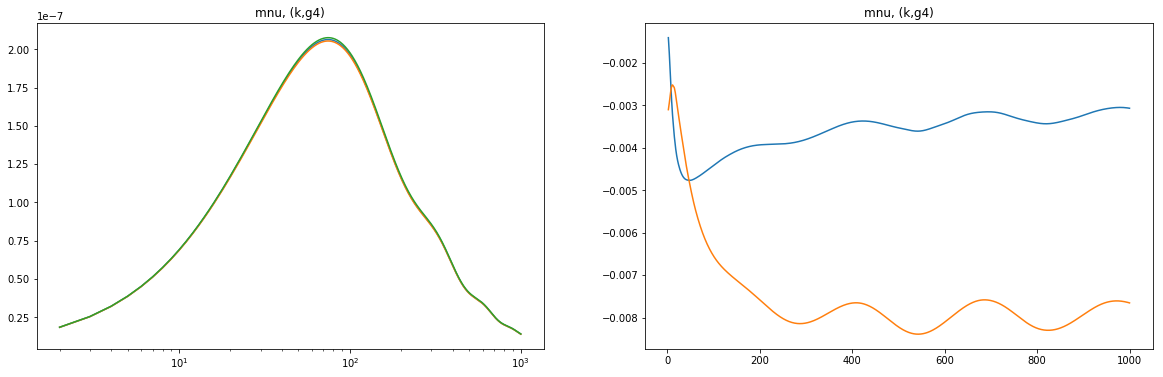

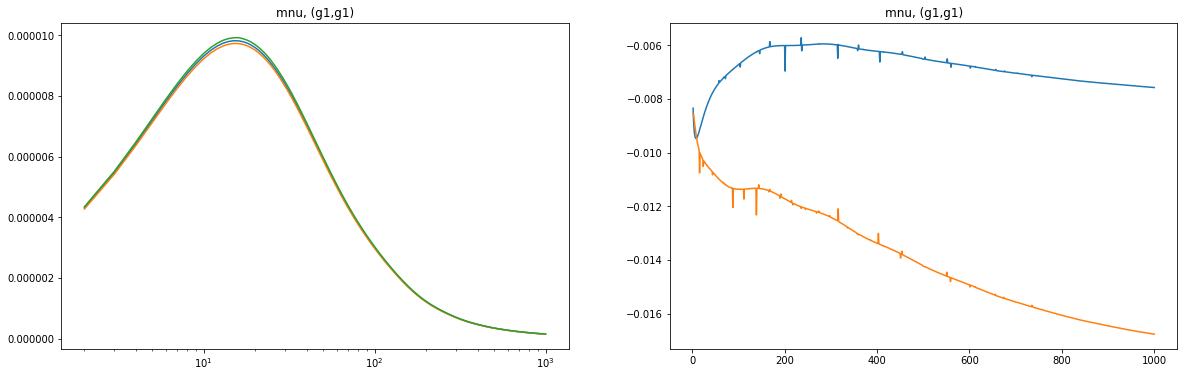

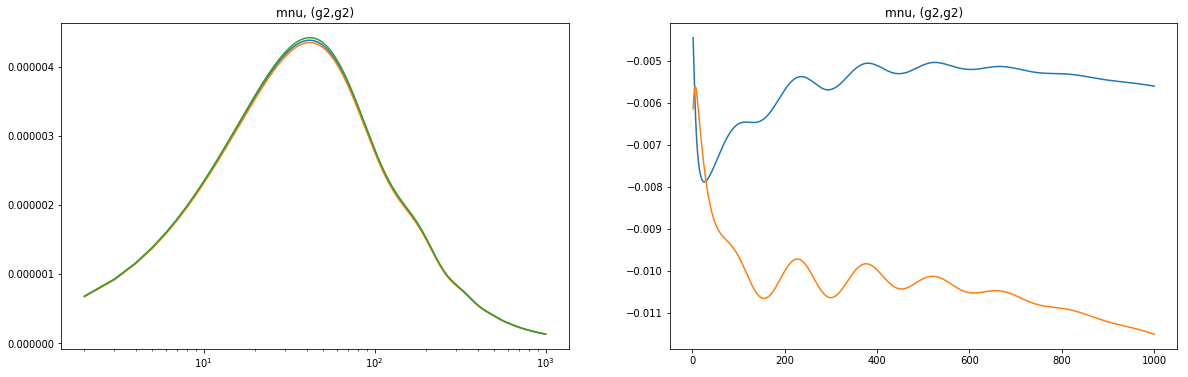

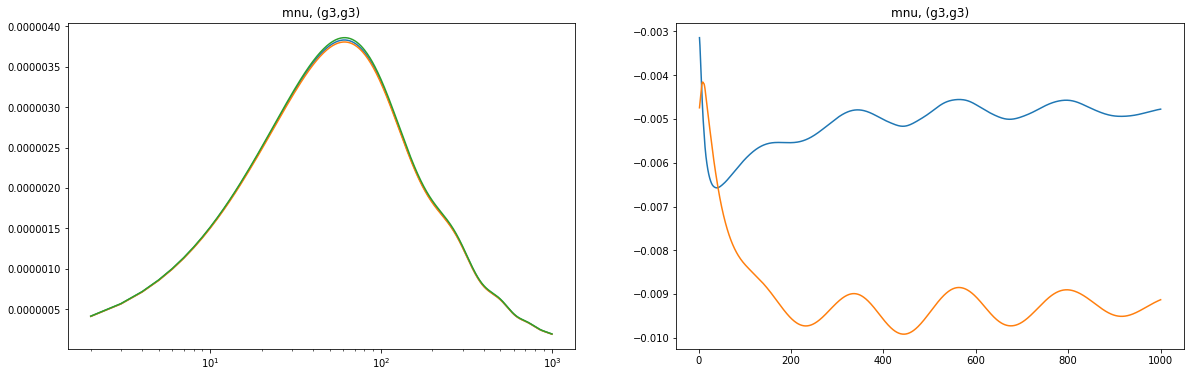

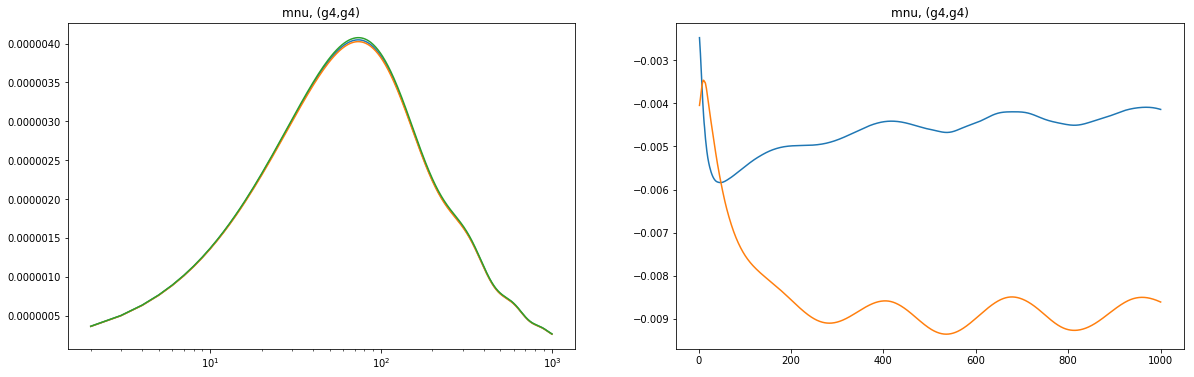

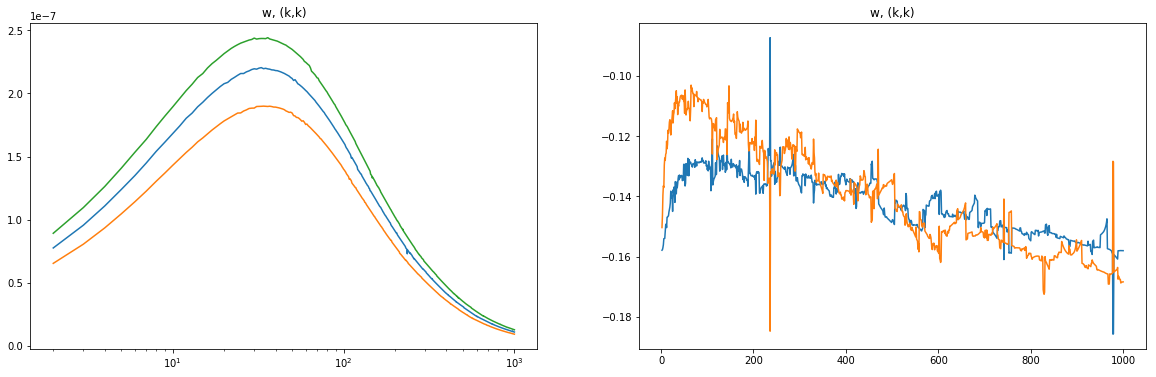

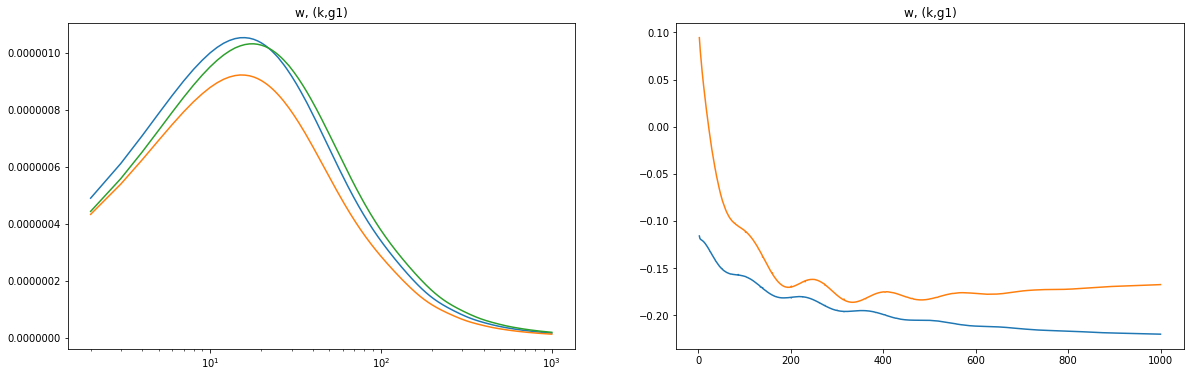

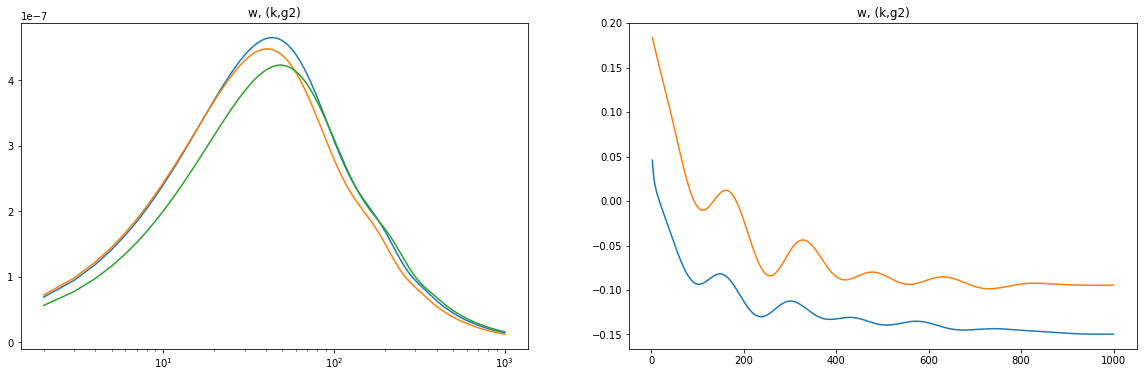

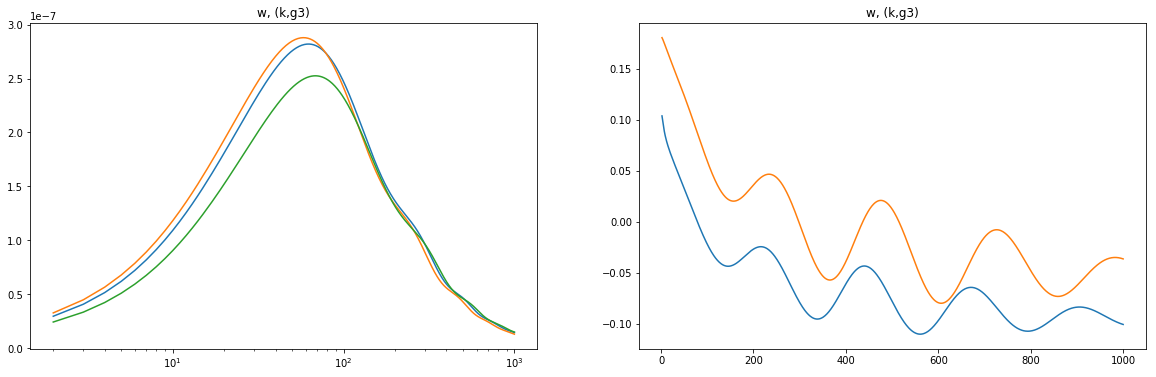

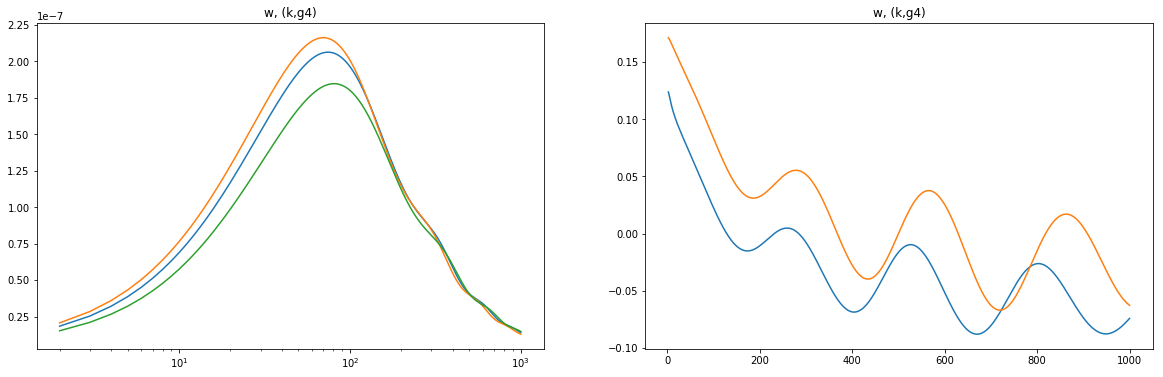

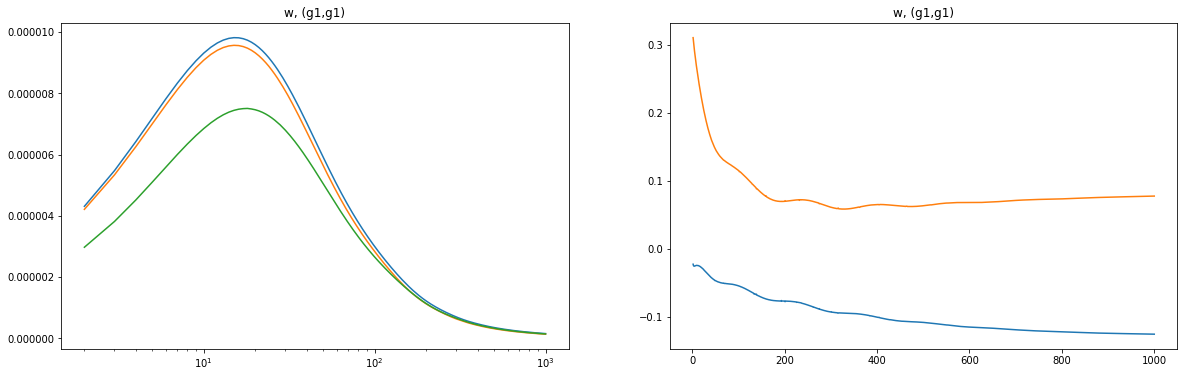

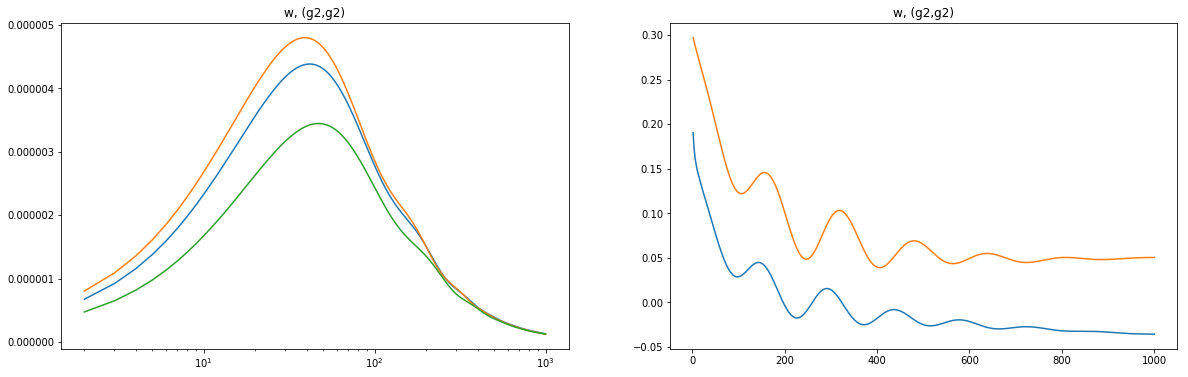

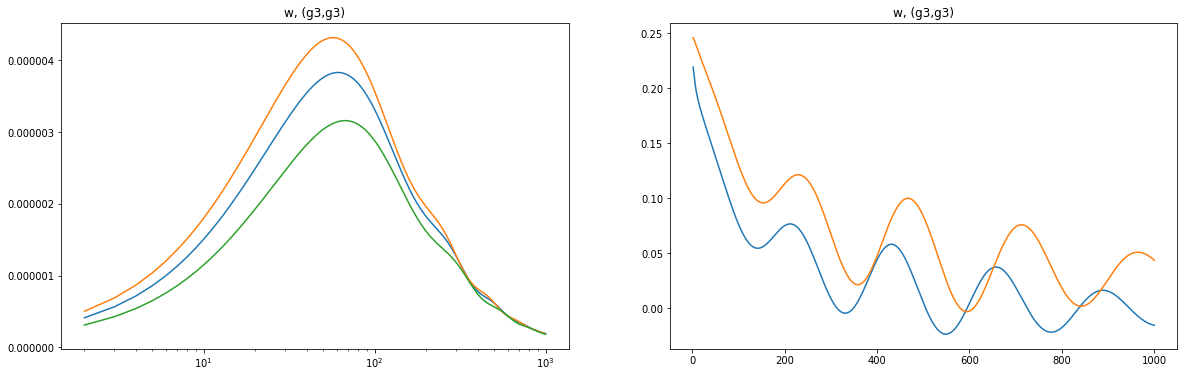

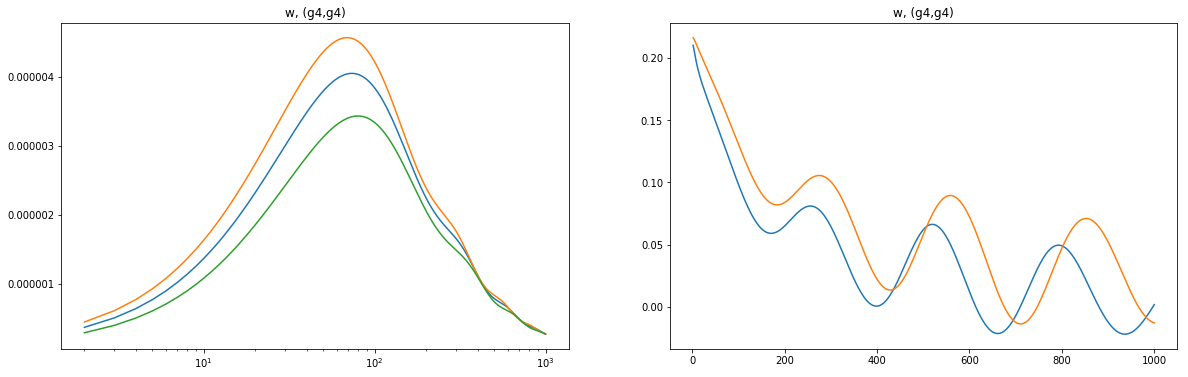

In [130]:
%matplotlib inline
for param in range(nCosParams):        
    for obs1 in range(nMaps):
        for obs2 in range(obs1,nMaps):
            if obs1 == 0 or obs1 == obs2:
                nominal = Fobj.crossCls[obs1,obs2]
                plus = Fobj.crossClsPlus[obs1,obs2,param]
                minus = Fobj.crossClsMinus[obs1,obs2,param]
                obsName = obsNames[obs1*nMaps+obs2 - obs1*(obs1+1)/2]
                f, axarr = plt.subplots(1,2,figsize=(20,6))
                
                plt.sca(axarr[0])
                plt.semilogx(ells,nominal)
                plt.semilogx(ells,plus)
                plt.semilogx(ells,minus)
                plt.title(paramList[param]+', ('+obsName+')')
                
                plt.sca(axarr[1])
                plt.plot(ells,(plus-nominal)/nominal)
                plt.plot(ells,(nominal-minus)/nominal)
                plt.title(paramList[param]+', ('+obsName+')')
                
                plt.show()

# Match Byeonghee's plots

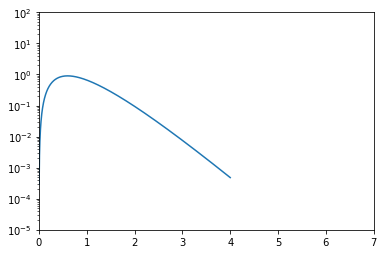

In [131]:
# dn/dz
zs = np.linspace(0,4,1000)
z0 = 0.3
dndzs = cp.modelDNDZ(zs,z0)
plt.semilogy(zs,dndzs)
plt.ylim([1e-5,1e2])
plt.xlim([0,7])
plt.show()

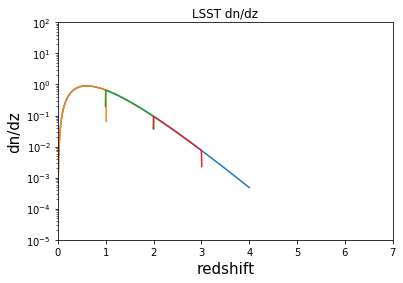

In [132]:
# now in bins
#dndzFuncs = []
for binNum in range(4):
    dndzF = cp.getDNDZinterp(binNum=binNum,zmin=0,zmax=4,nBins=4,z0=z0)
    plt.semilogy(zs,dndzF(zs))
plt.ylim([1e-5,1e2])
plt.xlim([0,7])
plt.xlabel('redshift',fontsize=15)
plt.ylabel('dn/dz',fontsize=15)
plt.title('LSST dn/dz')
plt.show()

(5, 5, 999)
5


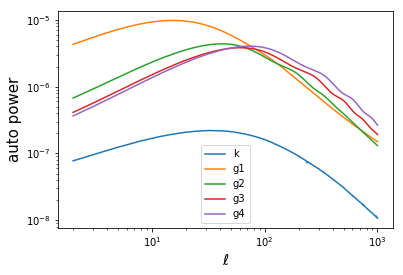

In [133]:
# plot auto power spectra
print Fobj.crossCls.shape
# auto power are on diagonal
print nMaps
labels = ['k','g1','g2','g3','g4']
for mapNum in range(nMaps):
    plt.loglog(ells,Fobj.crossCls[mapNum,mapNum],label=labels[mapNum])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel('auto power',fontsize=15)
plt.legend()
plt.show()

(5, 5, 999)
5


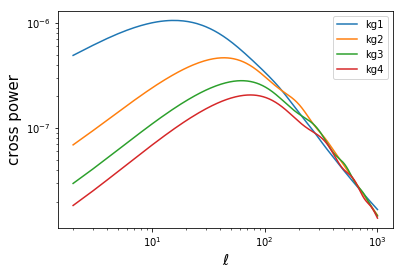

In [134]:
# plot kappa cross galaxy spectra
print Fobj.crossCls.shape
# auto power are on diagonal
print nMaps
labels = ['kk','kg1','kg2','kg3','kg4']
for mapNum in range(1,nMaps):
    plt.loglog(ells,Fobj.crossCls[0,mapNum],label=labels[mapNum])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel('cross power',fontsize=15)
plt.legend()
plt.show()

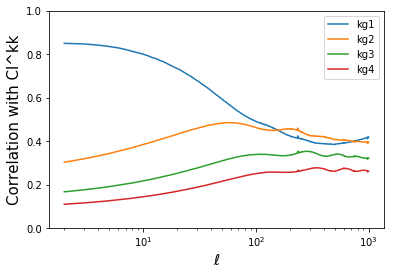

In [135]:
#plot correlation coefficients
labels = ['kk','kg1','kg2','kg3','kg4']
for mapNum in range(1,nMaps):
    Clkg = Fobj.crossCls[0,mapNum]
    Clkk = Fobj.crossCls[0,0]
    Clgg = Fobj.crossCls[mapNum,mapNum]
    r = Clkg/np.sqrt(Clkk*Clgg)
    plt.semilogx(ells,r,label=labels[mapNum])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel('Correlation with Cl^kk',fontsize=15)
plt.ylim([0,1])
plt.legend()
plt.show()

# Compare result against Byeonghee's result

In [136]:
for i,p in enumerate(paramList):
    print p, sigmas2[i]

ombh2 0.000248015669489
omch2 0.000788003996266
cosmomc_theta 1.78937887867e-05
As 1.49529669476e-11
ns 0.00308358316126
tau 2.91377124118
mnu 0.0133178089888
w 0.017098074712
bin1 0.00373669607237
bin2 0.00397730986367
bin3 0.00632521390216
bin4 0.00818064489161


In [137]:
# convert to sigma(b)/b
"""
binBs = Fobj.binBs
print binBs
sigmas2[-4:]/=binBs
print sigmas2
"""

'\nbinBs = Fobj.binBs\nprint binBs\nsigmas2[-4:]/=binBs\nprint sigmas2\n'

In [138]:
# Byeonghee's result:
# This used lmin 50, lmax 1000, halofit
sigmasB1 = {
    #sigma(b) (4 bins) =  [ 0.01220295  0.0092872   0.01058874  0.03529165]
    'cosmomc_theta' : 0.00015113283201,
    'ombh2' : 0.000504509008534,
    'omch2' : 0.00151341881388,
    'ns' : 0.00732594856064,
    'As' : 0.0618279762973*1e-9,
    'mnu' : 0.0564262366597,
    'w' : 0.088058950571,
    'tau' : 0.0595781322066,
    'bin1' : 0.01220295,
    'bin2' : 0.0092872,
    'bin3' : 0.01058874,
    'bin4' : 0.03529165
}
# This used lmin 50, lmax 1000, halofit, bias by bin
sigmasB2 = {
    'cosmomc_theta' : 7.32e-05,
    'ombh2' : 0.001178,
    'omch2' : 0.00253,
    'ns' : 0.01075,
    'As' : 0.0618279762973*1e-9, #B did not give me an updated value for As so this is just copied from sigmasB1
    'mnu' : 0.1104,
    'w' : 0.0933,
    'tau' : 8.6585,
    'bin1' : 0.0112,
    'bin2' : 0.0124,
    'bin3' : 0.0140,
    'bin4' : 0.0144
}
sigmasB = sigmasB2

In [139]:
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma_Z(k,g)','sigma_B(k,g)','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas2[i]
    Bi = sigmasB[paramList[i]]
    diff = (Bi-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Bi, "%5.3g" % diff ] )
print t


+---------------+--------------+--------------+---------------+
|   Parameter   | sigma_Z(k,g) | sigma_B(k,g) | percent diff. |
+---------------+--------------+--------------+---------------+
|     ombh2     |   0.000248   |   0.00118    |       375     |
|     omch2     |   0.000788   |   0.00253    |       221     |
| cosmomc_theta |   1.79e-05   |   7.32e-05   |       309     |
|       As      |   1.5e-11    |   6.18e-11   |       313     |
|       ns      |   0.00308    |    0.0107    |       249     |
|      tau      |     2.91     |     8.66     |       197     |
|      mnu      |    0.0133    |     0.11     |       729     |
|       w       |    0.0171    |    0.0933    |       446     |
|      bin1     |   0.00374    |    0.0112    |       200     |
|      bin2     |   0.00398    |    0.0124    |       212     |
|      bin3     |   0.00633    |    0.014     |       121     |
|      bin4     |   0.00818    |    0.0144    |        76     |
+---------------+--------------+--------